# CenterResnet Starter


I am very new to these concepts so I am trying out by changing this amazing and probably only 3D model related awesome public kernel by Ruslan
https://www.kaggle.com/hocop1/centernet-baseline

Most of the codes are loaned from there . There are other codes that I took from OFT implementation github . But I dont know what is OFT , so I have not yet implemented it . 

My current score is not from this kernel( as there are some errors in this kernel) , but from some simple architecture modification of the original public kernel. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

PATH = '../input/pku-autonomous-driving/'
os.listdir(PATH)

['car_models_json',
 'test_masks.zip',
 'test_images',
 'test_images.zip',
 'sample_submission.csv',
 'car_models',
 'train.csv',
 'camera.zip',
 'test_masks',
 'train_masks',
 'car_models_json.zip',
 'train_masks.zip',
 'train_images',
 'camera',
 'train_images.zip',
 'car_models.zip']

In [2]:
## Constants
SWITCH_LOSS_EPOCH = 5

# Load data

In [3]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

**ImageId** column contains names of images:

In [4]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

#plt.figure(figsize=(15,8))
#plt.imshow(img);

In [5]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [6]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


# Data distributions

In [7]:
lens = [len(str2coords(s)) for s in train['PredictionString']]

#plt.figure(figsize=(15,6))
#sns.countplot(lens);
#plt.xlabel('Number of cars in image');

I guess, pitch and yaw are mixed up in this dataset. Pitch cannot be that big. That would mean that cars are upside down.

In [8]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

# plt.figure(figsize=(15,6))
# sns.distplot(reduce(lambda a, b: a + b, [[rotate(c['roll'], np.pi) for c in str2coords(s)] for s in train['PredictionString']]));
# plt.xlabel('roll rotated by pi')
# plt.show()

# 2D Visualization

In [9]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

#plt.figure(figsize=(14,14))
#plt.imshow(imread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
#plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

In [10]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

# Image preprocessing

In [11]:
IMG_WIDTH = 2048
IMG_HEIGHT = IMG_WIDTH // 4
MODEL_SCALE = 8

def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] //2 :]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

# PyTorch Dataset

In [12]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img0 = imread(img_name, True)
        img = preprocess_image(img0)
        img = np.rollaxis(img, 2, 0)
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr]
    
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test


In [13]:
import imgaug.augmenters as iaa

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
        iaa.Add((-10, 10), per_channel=0.5),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

transforms = ImgAugTransform()

train_dataset = CarDataset(df_train, train_images_dir, transform = transforms)
dev_dataset = CarDataset(df_dev, train_images_dir)
test_dataset = CarDataset(df_test, test_images_dir)

/home/dohee/anaconda3/envs/CenterNet/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [14]:
BATCH_SIZE = 4

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [15]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 23, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model

def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

In [16]:
from dlav0 import get_pose_net as get_dlav0
#from pose_dla_dcn import get_pose_net as get_dlav0

In [17]:
_model_factory = {
  #'res': get_pose_net, # default Resnet with deconv
  'dlav0': get_dlav0, # default DLAup
  #'dla': get_dla_dcn,
  #'resdcn': get_pose_net_dcn,
  #'hourglass': get_large_hourglass_net,
}

In [18]:
def create_model(arch, heads, head_conv):
    num_layers = int(arch[arch.find('_') + 1:]) if '_' in arch else 0
    arch = arch[:arch.find('_')] if '_' in arch else arch
    arch = 'dlav0'
    get_model = _model_factory[arch]
    model = get_model(num_layers=num_layers, heads=heads, head_conv=head_conv)
    return model

In [19]:
model = create_model('dla_34', {'hm': 1, 'reg' : 7} , 256)#{'hm': 3, 'dep': 1, 'rot': 8, 'dim': 3, 'wh': 2, 'reg': 2},256)

In [20]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 18 #6

#model = CentResnet(8).to(device)
model.cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
#optimizer =  optim.Adam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

cuda


In [21]:
# Load Model

In [22]:
# model.load_state_dict(torch.load('./model-dla34_w08.pth'))
# model.eval();

In [23]:
# def gaussian_radius(det_size, min_overlap=0.7):
#     height, width = det_size

#     a1  = 1
#     b1  = (height + width)
#     c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
#     sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
#     r1  = (b1 + sq1) / 2

#     a2  = 4
#     b2  = 2 * (height + width)
#     c2  = (1 - min_overlap) * width * height
#     sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
#     r2  = (b2 + sq2) / 2

#     a3  = 4 * min_overlap
#     b3  = -2 * min_overlap * (height + width)
#     c3  = (min_overlap - 1) * width * height
#     sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
#     r3  = (b3 + sq3) / 2
#     return min(r1, r2, r3)
# def gaussian2D(shape, sigma=1):
#     m, n = [(ss - 1.) / 2. for ss in shape]
#     y, x = np.ogrid[-m:m+1,-n:n+1]

#     h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
#     h[h < np.finfo(h.dtype).eps * h.max()] = 0
#     return h
# def draw_msra_gaussian(heatmap, center, sigma):
#     tmp_size = sigma * 3
#     mu_x = int(center[0] + 0.5)
#     mu_y = int(center[1] + 0.5)
#     w, h = heatmap.shape[0], heatmap.shape[1]
#     ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
#     br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
#     if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
#         return heatmap
#     size = 2 * tmp_size + 1
#     x = np.arange(0, size, 1, np.float32)
#     y = x[:, np.newaxis]
    
#     x0 = y0 = size // 2
#     g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
#     g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
#     g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
#     img_x = max(0, ul[0]), min(br[0], h)
#     img_y = max(0, ul[1]), min(br[1], w)
    
    
#     heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
#         heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
#         g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
#     return heatmap

# def gaussian_mask(mask):
#     xlist, ylist = np.where(mask == 1)
#     masklist = [(i,j) for i, j in zip(xlist, ylist)]
#     hm = np.zeros(mask.shape) 

#     for (y,x) in masklist:
#         bbox = np.array([x-1, y-1, x+1, y+1])
#         h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
#         radius = gaussian_radius((h, w))    
#         ct = np.array([x,y], dtype=np.float32)
#         ct_int = ct.astype(np.int32)
#         hm[int(bbox[1]): int(bbox[3]), int(bbox[0]): int(bbox[2])] = 0.9999    
#         gm =+ draw_msra_gaussian(hm, ct, radius) # np.exp((y-5)/200)

#     #plt.figure(figsize=(16,16))
#     #plt.imshow(gm, vmin=0, vmax=1)
#     #plt.show()
    
#     return gm



In [24]:
# Gaussian

def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    
    
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap

def gaussian_mask(mask):
    xlist, ylist = np.where(mask == 1)
    masklist = [(i,j) for i, j in zip(xlist, ylist)]
    hm = np.zeros(mask.shape) 

    for (y,x) in masklist:
        bbox = np.array([x-1, y-1, x+1, y+1])
        h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
        radius = gaussian_radius((h, w))
        ct = np.array([(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2], dtype=np.float32)
        ct_int = ct.astype(np.int32)
        hm[int(bbox[1]): int(bbox[3]), int(bbox[0]): int(bbox[2])] = 0.9999    
        gm =+ draw_msra_gaussian(hm, ct, 2) # np.exp((y-5)/200)

    #plt.figure(figsize=(16,16))
    #plt.imshow(gm, vmin=0, vmax=1)
    #plt.show()
    
    return gm




In [25]:
from tqdm import tqdm
def apply_gaussian(dataset):
    for i in tqdm(range(len(dataset))):
        dataset[i][1] = gaussian_mask(dataset[i][1])    
    return dataset

train_dataset = apply_gaussian(train_dataset)

100%|██████████| 4219/4219 [30:12<00:00,  2.33it/s]


In [26]:
# from tqdm import tqdm
# def apply_gaussian(dataset):
#     for i in tqdm(range(len(dataset))):
#         dataset[i][1] = gaussian_mask(dataset[i][1])    
#     return dataset

# train_dataset = apply_gaussian(train_dataset)

# Training

In [27]:
import random

def train(epoch, history=None):
    model.train()
    t = tqdm(train_loader)
    numlist = [0,1]
    
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(t):
        
        # horizontal flip
        if random.sample(numlist, 1)[0]==0:
            img_batch = torch.flip(img_batch, [3])
            mask_batch = torch.flip(mask_batch, [2])
            regr_batch = torch.flip(regr_batch, [3])
        
        
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        
        if epoch < SWITCH_LOSS_EPOCH :
            loss, mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,1)
        else:
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5)  
        
        t.set_description(f'train_loss (l={loss:.3f})(m={mask_loss:.2f}) (r={regr_loss:.4f}')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()

    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}\tMaskLoss: {:.6f}\tRegLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data,
        mask_loss.data,
        regr_loss.data))

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            if epoch < SWITCH_LOSS_EPOCH :
                loss,mask_loss, regr_loss= criterion(output, mask_batch, regr_batch,1, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
                loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.5, size_average=False)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data 

    
    valid_loss /= len(dev_loader.dataset)
    valid_mask_loss /= len(dev_loader.dataset)
    valid_regr_loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()

    
    print('Dev loss: {:.4f}'.format(valid_loss))

In [28]:
def _neg_loss(pred, gt):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

def criterion(prediction, mask, regr, weight=0.8, size_average=True):
    # Binary mask loss
    
    pred_mask = prediction[0]['hm']
    pred_mask = torch.sigmoid(pred_mask[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)

    #mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    #mask_loss = -mask_loss.mean(0).sum()


    mask_loss = _neg_loss(pred_mask,mask)
    
    # Regression L1 loss
    #pred_regr = prediction[:, 1:]
    pred_regr = prediction[0]['reg']
    #regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1


    regr_loss = (torch.min(torch.abs(pred_regr - regr), torch.abs((pred_regr - regr)**2)).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    # smooth l1 - torch.min(torch.abs(pred_regr - regr), torch.abs((pred_regr - regr)**2))
    regr_loss = regr_loss.mean(0)

    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    #if not size_average:
    #    loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [29]:
%%time
import gc

history = pd.DataFrame()




for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    evaluate(epoch, history)



train_loss (l=1.297)(m=1.30) (r=1.2610: 100%|██████████| 1055/1055 [07:02<00:00,  2.50it/s]


Train Epoch: 0 	LR: 0.001000	Loss: 1.297038	MaskLoss: 1.297038	RegLoss: 1.261049


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.3038


train_loss (l=1.226)(m=1.23) (r=1.4580: 100%|██████████| 1055/1055 [07:05<00:00,  2.48it/s]


Train Epoch: 1 	LR: 0.001000	Loss: 1.225689	MaskLoss: 1.225689	RegLoss: 1.458034


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.2617


train_loss (l=0.905)(m=0.91) (r=1.4043: 100%|██████████| 1055/1055 [07:05<00:00,  2.48it/s]


Train Epoch: 2 	LR: 0.001000	Loss: 0.905458	MaskLoss: 0.905458	RegLoss: 1.404338


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.2375


train_loss (l=0.998)(m=1.00) (r=1.3411: 100%|██████████| 1055/1055 [07:05<00:00,  2.48it/s]


Train Epoch: 3 	LR: 0.001000	Loss: 0.998439	MaskLoss: 0.998439	RegLoss: 1.341105


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.2463


train_loss (l=0.745)(m=0.74) (r=1.4770: 100%|██████████| 1055/1055 [07:04<00:00,  2.48it/s]


Train Epoch: 4 	LR: 0.001000	Loss: 0.744808	MaskLoss: 0.744808	RegLoss: 1.477017


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.2471


train_loss (l=0.481)(m=0.66) (r=0.2976: 100%|██████████| 1055/1055 [07:05<00:00,  2.48it/s]


Train Epoch: 5 	LR: 0.001000	Loss: 0.480723	MaskLoss: 0.663869	RegLoss: 0.297576


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1683


train_loss (l=0.493)(m=0.79) (r=0.1947: 100%|██████████| 1055/1055 [07:05<00:00,  2.48it/s]


Train Epoch: 6 	LR: 0.000100	Loss: 0.493211	MaskLoss: 0.791707	RegLoss: 0.194714


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1545


train_loss (l=0.575)(m=0.84) (r=0.3097: 100%|██████████| 1055/1055 [07:06<00:00,  2.47it/s]


Train Epoch: 7 	LR: 0.000100	Loss: 0.575257	MaskLoss: 0.840849	RegLoss: 0.309664
Dev loss: 0.1577


train_loss (l=0.669)(m=0.74) (r=0.5989: 100%|██████████| 1055/1055 [07:07<00:00,  2.47it/s]


Train Epoch: 8 	LR: 0.000100	Loss: 0.669333	MaskLoss: 0.739720	RegLoss: 0.598947


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1502


train_loss (l=0.568)(m=0.86) (r=0.2796: 100%|██████████| 1055/1055 [07:07<00:00,  2.47it/s]


Train Epoch: 9 	LR: 0.000100	Loss: 0.568216	MaskLoss: 0.856823	RegLoss: 0.279609


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1538


train_loss (l=0.534)(m=0.73) (r=0.3416: 100%|██████████| 1055/1055 [07:07<00:00,  2.47it/s]


Train Epoch: 10 	LR: 0.000100	Loss: 0.534200	MaskLoss: 0.726810	RegLoss: 0.341590


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1511


train_loss (l=0.433)(m=0.70) (r=0.1706: 100%|██████████| 1055/1055 [07:07<00:00,  2.47it/s]


Train Epoch: 11 	LR: 0.000100	Loss: 0.433338	MaskLoss: 0.696109	RegLoss: 0.170566


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1524


train_loss (l=0.423)(m=0.59) (r=0.2536: 100%|██████████| 1055/1055 [07:08<00:00,  2.46it/s]

Train Epoch: 12 	LR: 0.000010	Loss: 0.422977	MaskLoss: 0.592345	RegLoss: 0.253610



  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1479


train_loss (l=0.375)(m=0.67) (r=0.0813: 100%|██████████| 1055/1055 [07:06<00:00,  2.47it/s]


Train Epoch: 13 	LR: 0.000010	Loss: 0.375331	MaskLoss: 0.669372	RegLoss: 0.081291


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1445


train_loss (l=0.473)(m=0.59) (r=0.3532: 100%|██████████| 1055/1055 [07:09<00:00,  2.46it/s]


Train Epoch: 14 	LR: 0.000010	Loss: 0.473166	MaskLoss: 0.593128	RegLoss: 0.353204


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1451


train_loss (l=0.452)(m=0.71) (r=0.1931: 100%|██████████| 1055/1055 [07:07<00:00,  2.47it/s]


Train Epoch: 15 	LR: 0.000010	Loss: 0.452184	MaskLoss: 0.711238	RegLoss: 0.193129


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1473


train_loss (l=0.496)(m=0.68) (r=0.3078: 100%|██████████| 1055/1055 [07:08<00:00,  2.46it/s]


Train Epoch: 16 	LR: 0.000010	Loss: 0.496362	MaskLoss: 0.684911	RegLoss: 0.307813


  0%|          | 0/1055 [00:00<?, ?it/s]

Dev loss: 0.1618


train_loss (l=0.449)(m=0.62) (r=0.2757: 100%|██████████| 1055/1055 [07:08<00:00,  2.46it/s]

Train Epoch: 17 	LR: 0.000010	Loss: 0.449485	MaskLoss: 0.623248	RegLoss: 0.275723


Dev loss: 0.1535
CPU times: user 4h 18min 35s, sys: 58min 43s, total: 5h 17min 19s
Wall time: 2h 9min 7s


In [30]:
1

1

In [31]:
torch.save(model.state_dict(), './model-dla34-G_2-F-aug'+'_'+'w08'+'.pth')

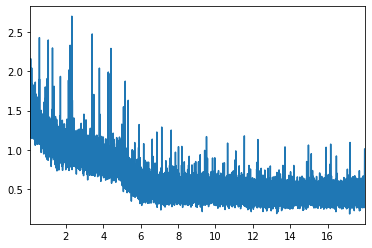

In [32]:
history['train_loss'].iloc[100:].plot();

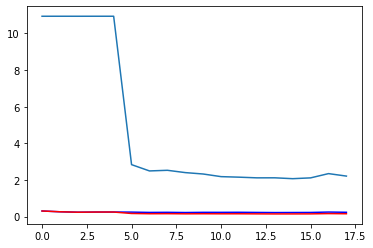

In [33]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss', color = 'blue');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss', color = 'red');
plt.show()

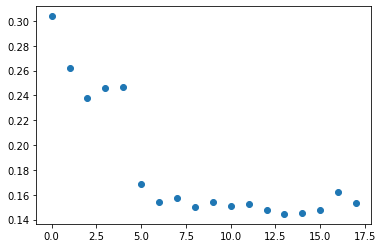

In [34]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

In [35]:
# model.load_state_dict(torch.load( './model-dla34'+'_'+'w08'+'.pth'))
# model.eval()

# Visualize predictions

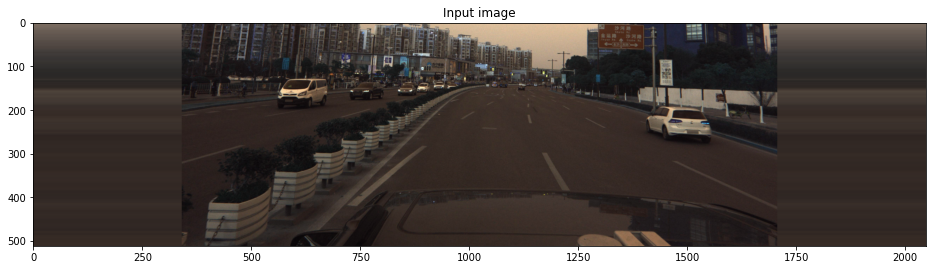

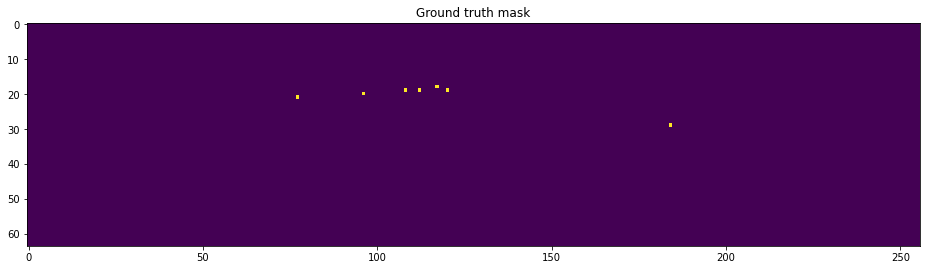

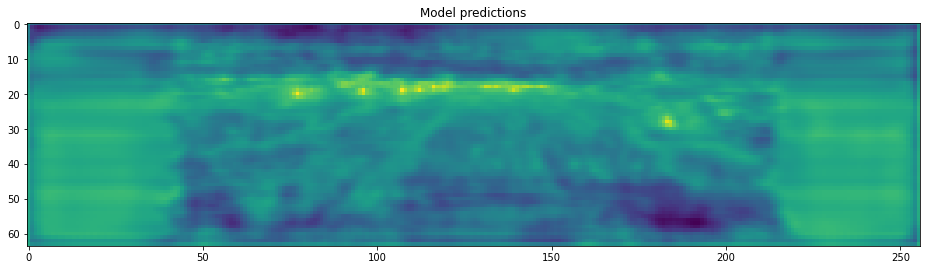

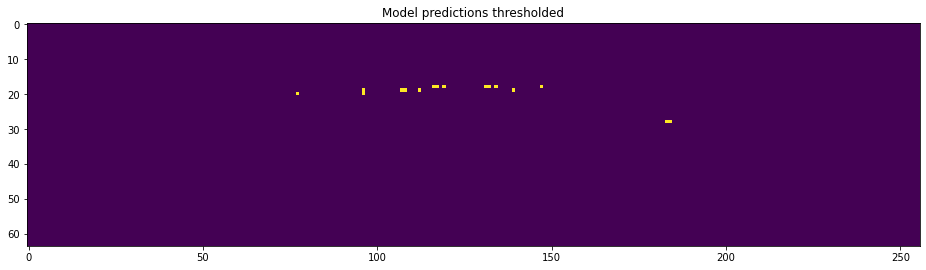

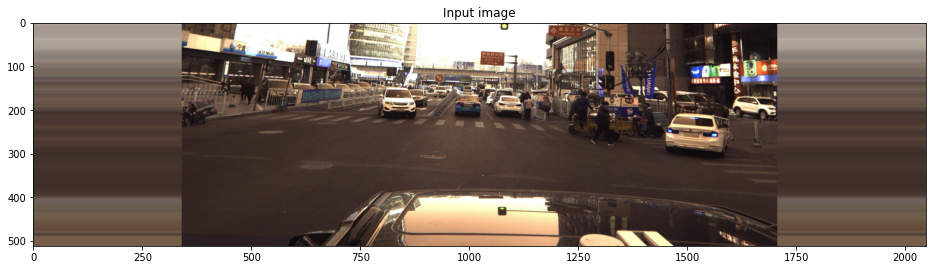

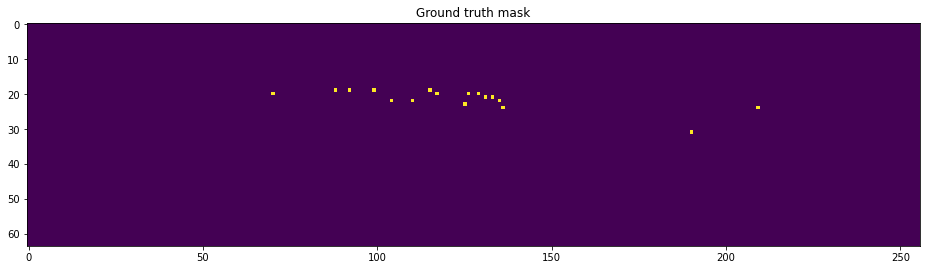

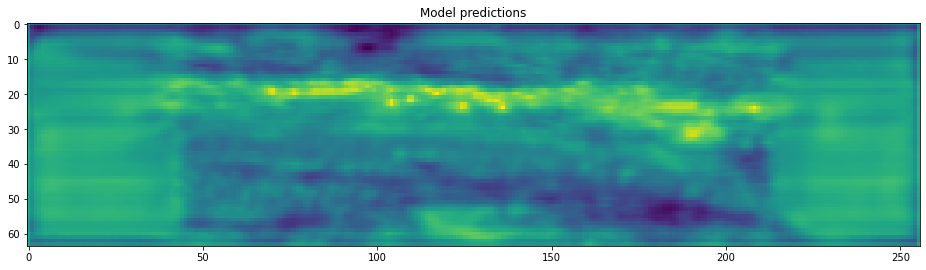

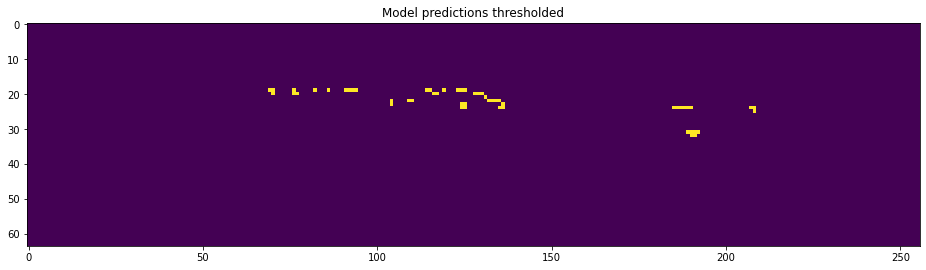

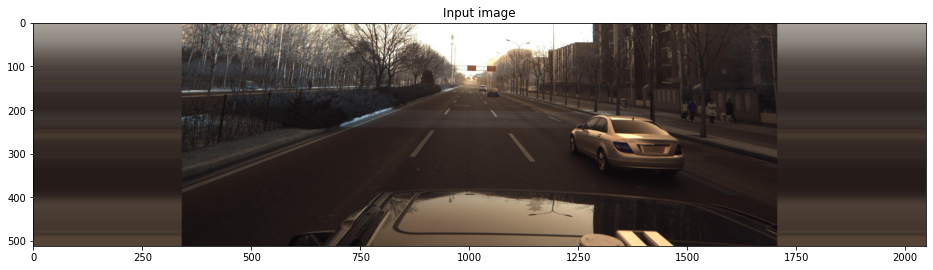

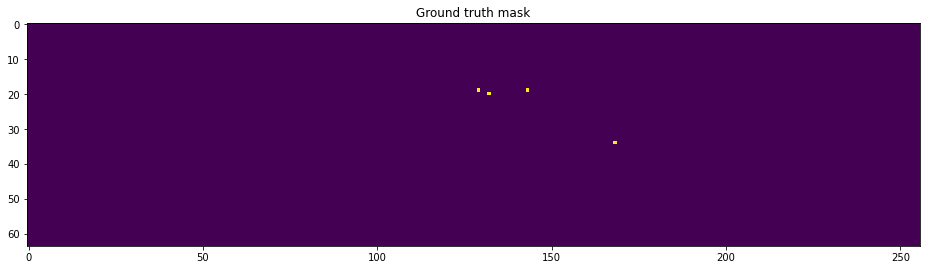

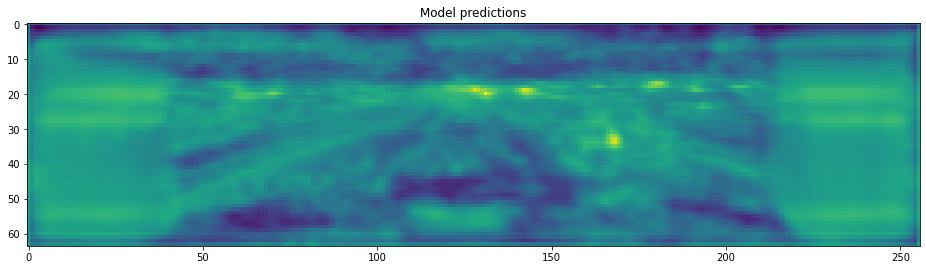

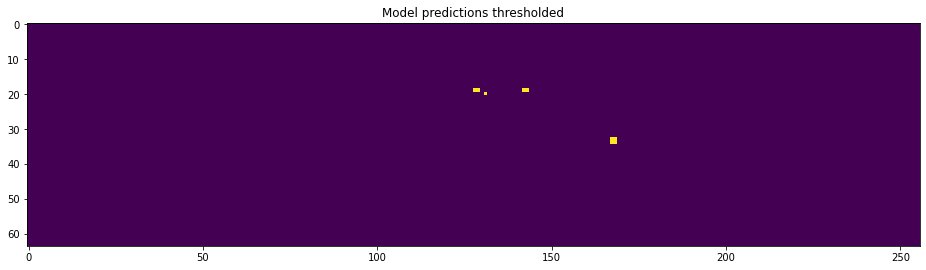

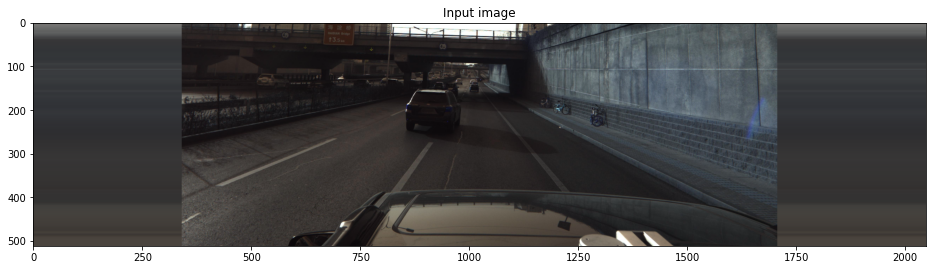

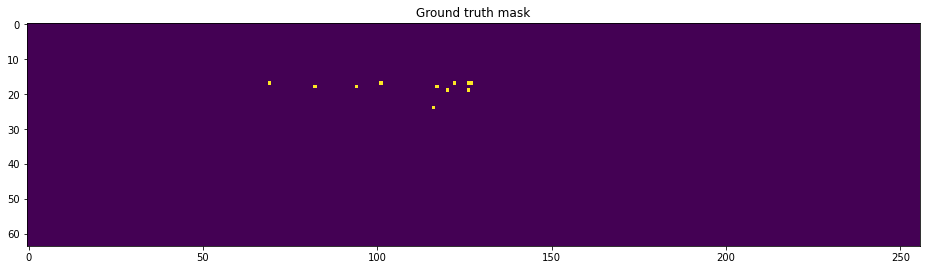

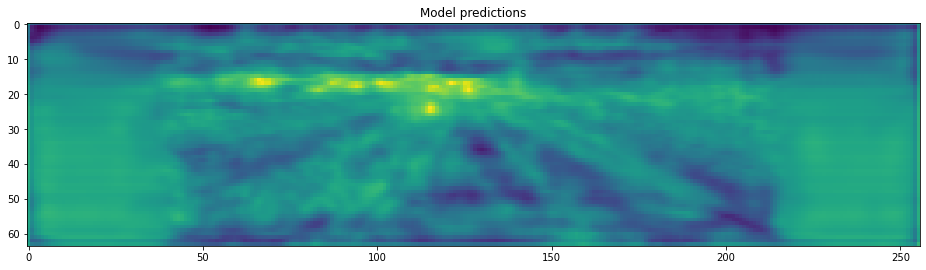

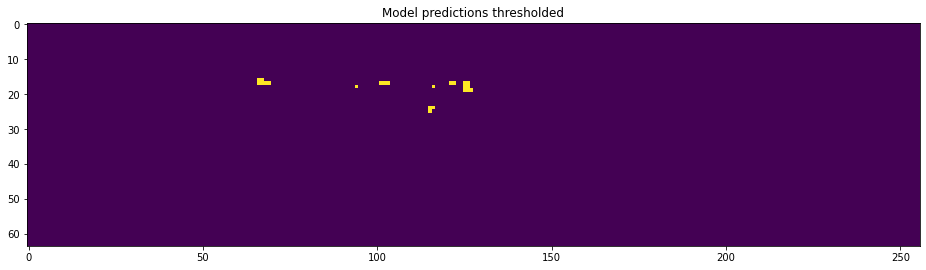

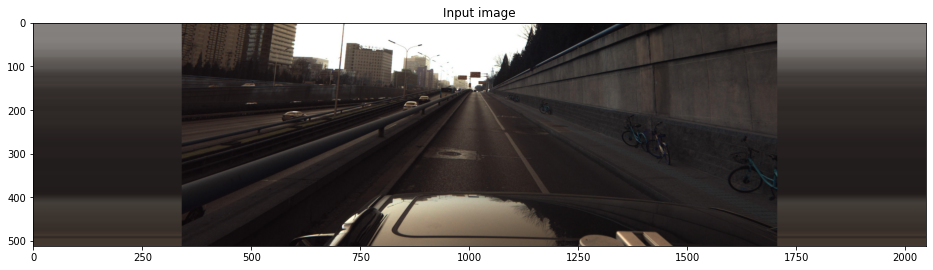

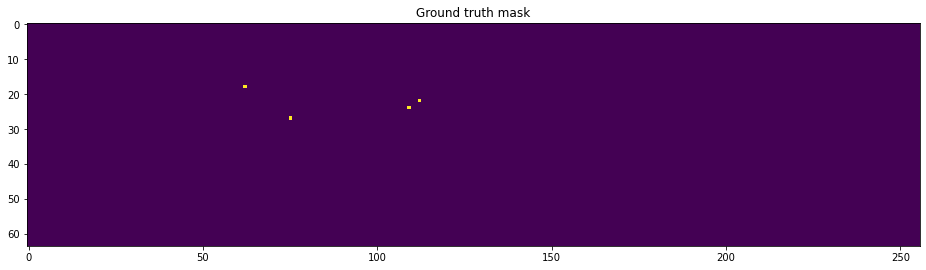

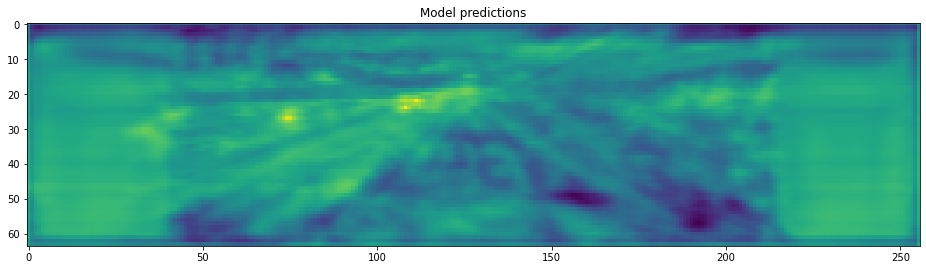

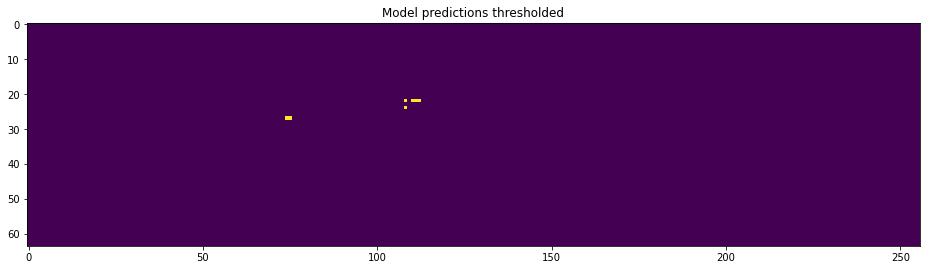

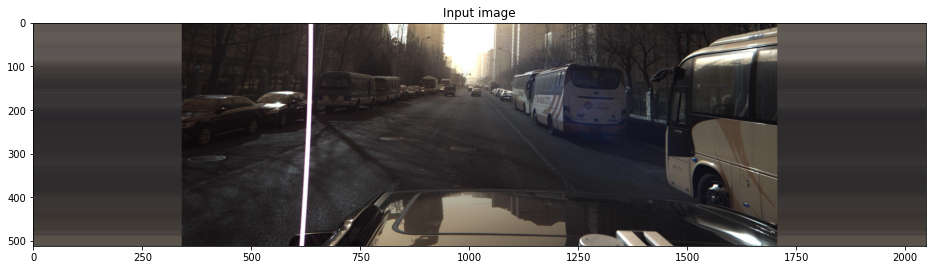

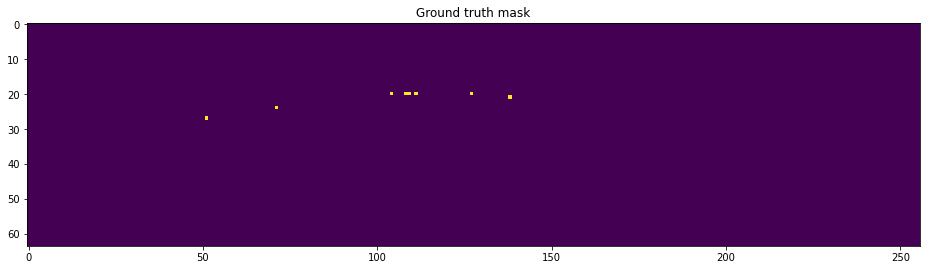

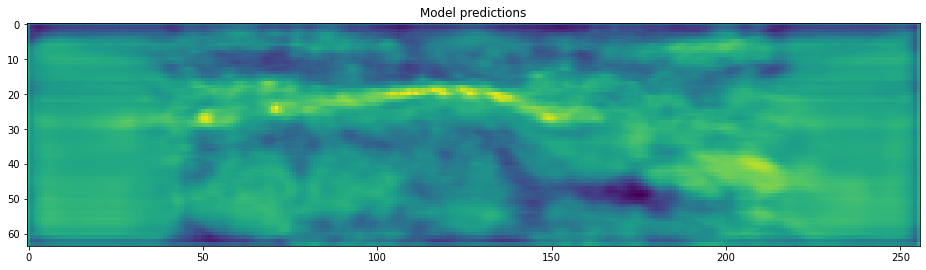

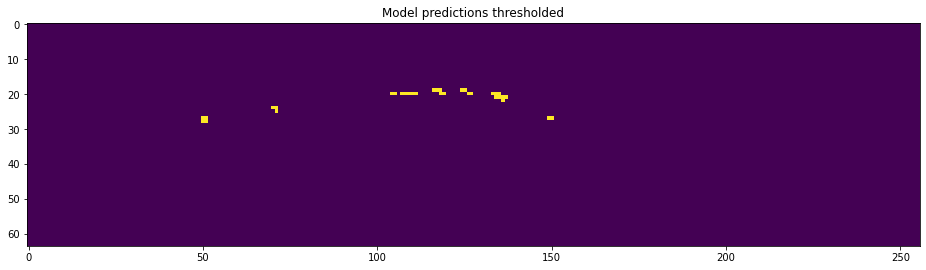

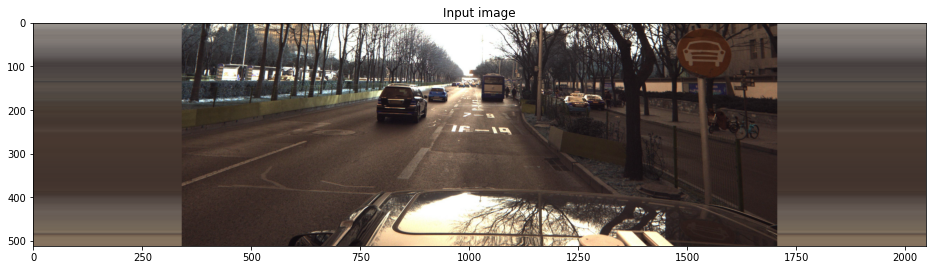

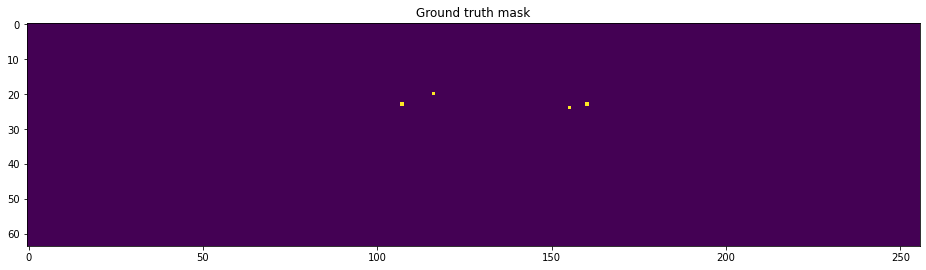

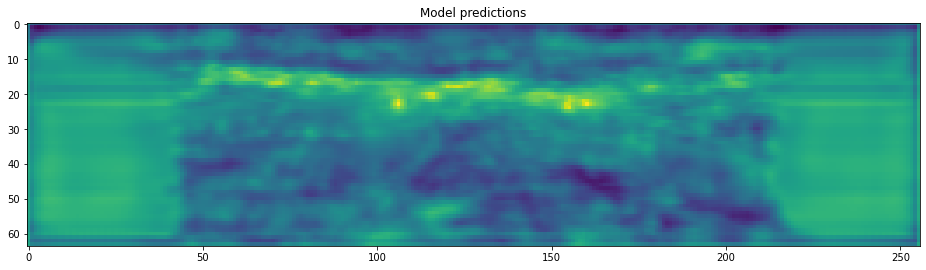

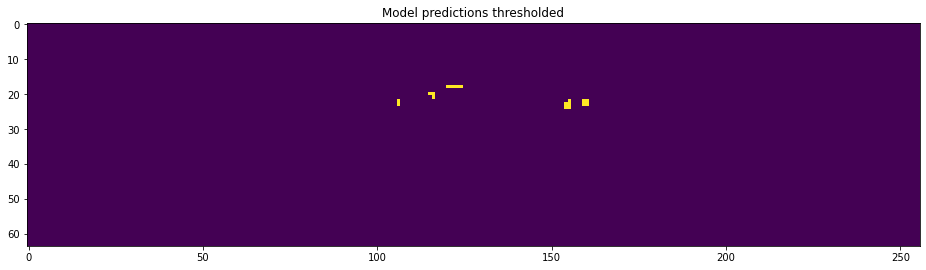

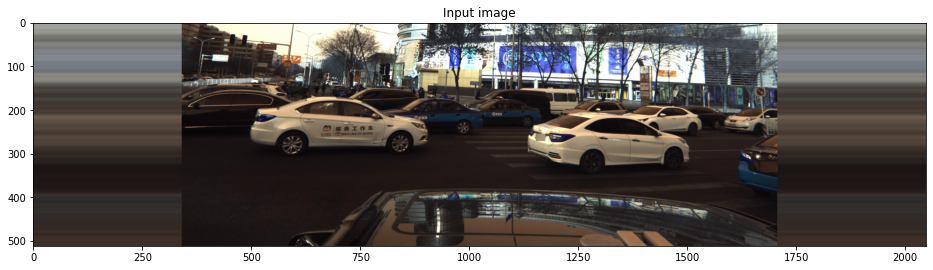

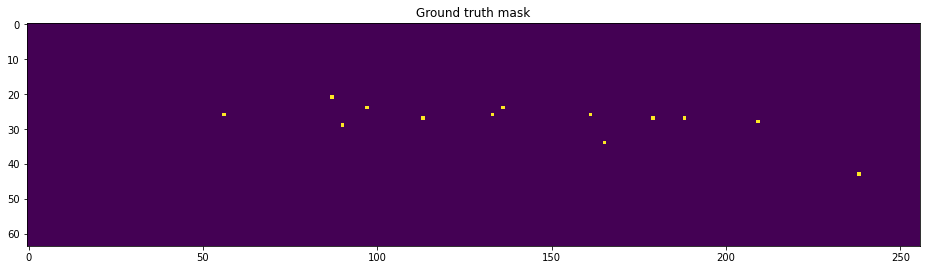

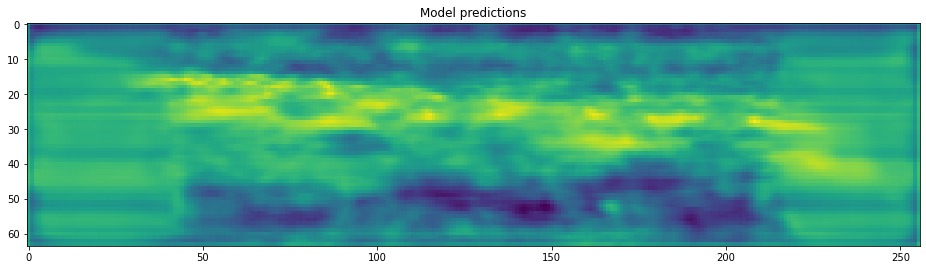

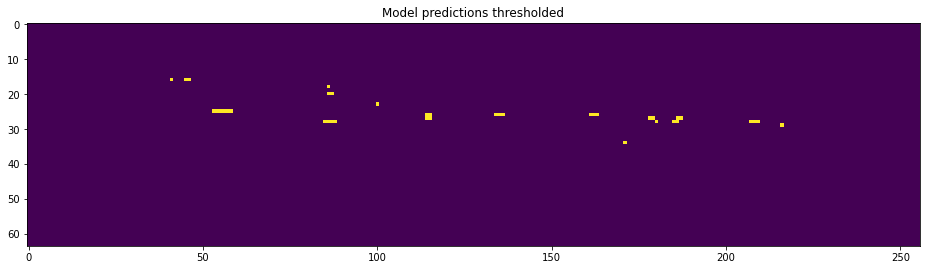

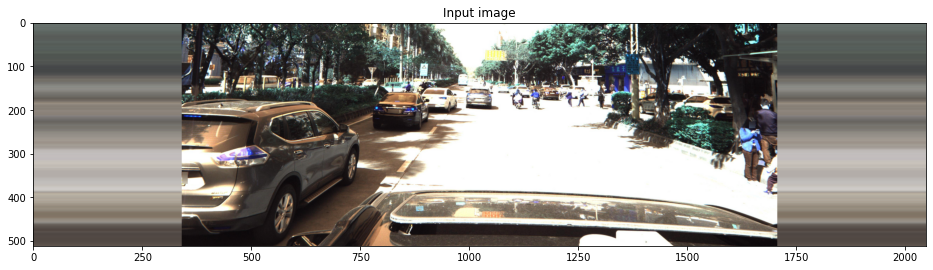

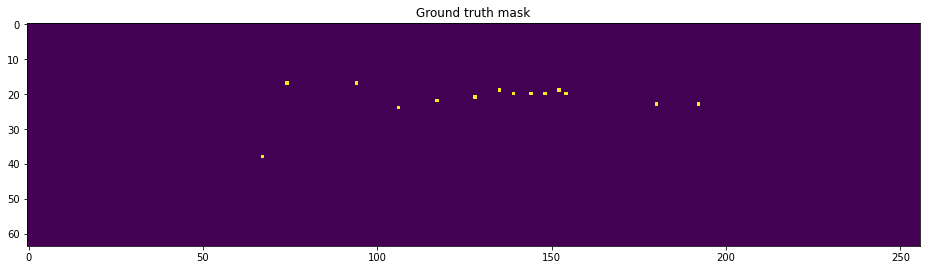

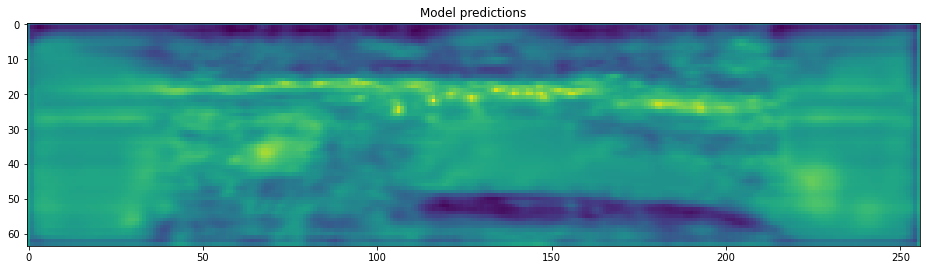

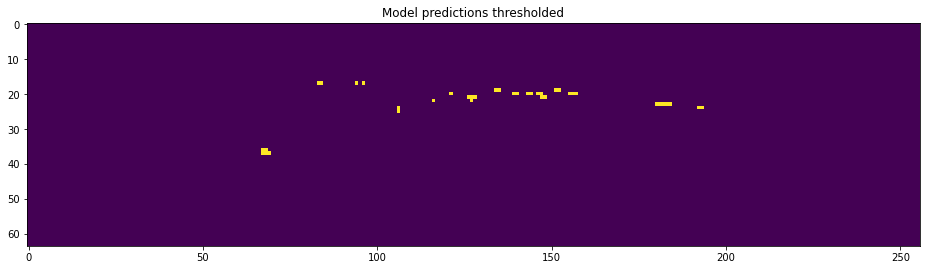

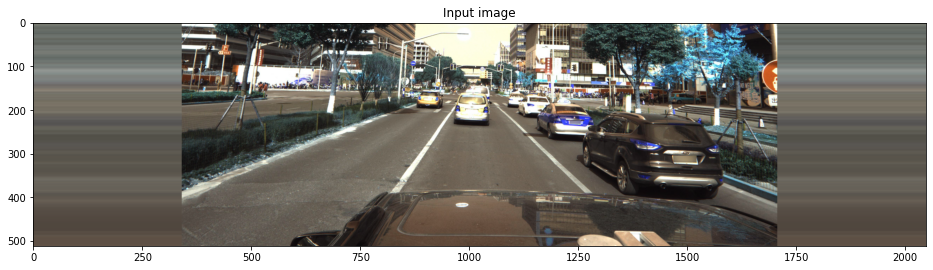

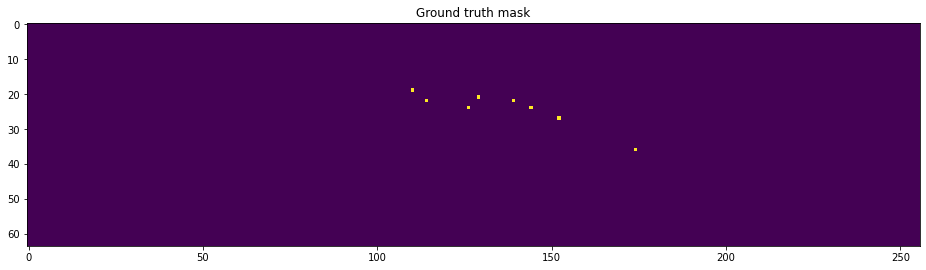

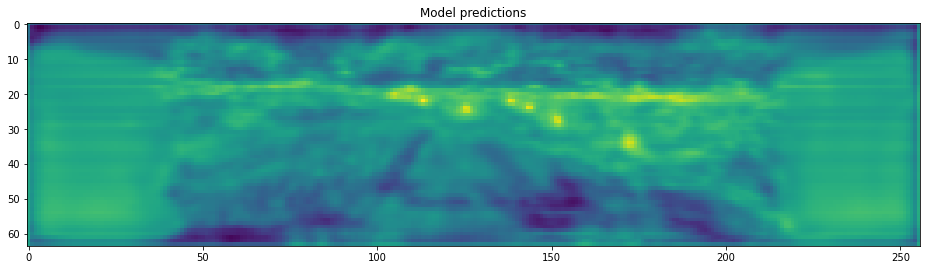

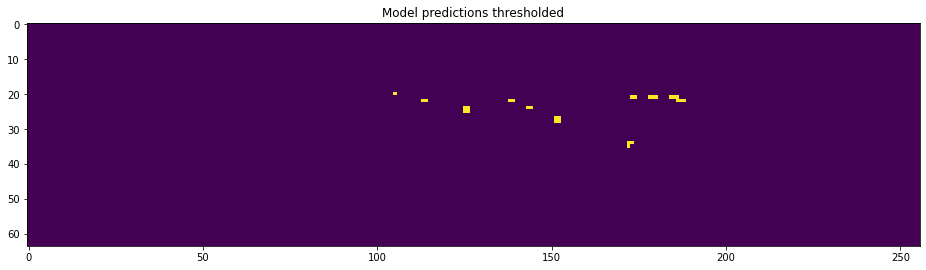

In [36]:
for i in range(10,20):
    img, mask, regr = dev_dataset[i]

    plt.figure(figsize=(16,16))
    plt.title('Input image')
    plt.imshow(np.rollaxis(img, 0, 3))
    plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Ground truth mask')
    plt.imshow(mask)
    plt.show()

    output = model(torch.tensor(img[None]).to(device))
    logits = output[0]['hm'].data.cpu().numpy()

    plt.figure(figsize=(16,16))
    plt.title('Model predictions')
    plt.imshow(logits[0,0])
    plt.show()


    plt.figure(figsize=(16,16))
    plt.title('Model predictions thresholded')
    plt.imshow(logits[0,0] > -1)
    plt.show()
    


In [37]:
# ## Simple test of probabilities
# act = torch.nn.Sigmoid()
# logtens = torch.from_numpy(logits)
# probs = act(logtens)
# probs = probs[probs>0.03]
# print(probs)

In [38]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

# Evaluation

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
import matplotlib.pyplot as plt
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df



#def str2coords(s, names):
#    coords = []
#    for l in np.array(s.split()).reshape([-1, 7]):
#        coords.append(dict(zip(names, l.astype('float'))))
#    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

def print_pr_curve(result_flg, scores, recall_total=1):
    average_precision = average_precision_score(result_flg, scores)
    precision, recall, _ = precision_recall_curve(result_flg, scores)
    recall *= recall_total
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

In [40]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores


# validation prediction

In [41]:
threshold1 = -1
threshold2 = 0
threshold3 = 0.2

In [42]:
# map: 0.10844716601852893 # -2
# map: 0.11908345067814112 # -3
# map: 0.1279842909587167  # -4
# map: 0.13395854895945764 # -5 
# map: 0.1383288800848642  # -6
# map: 0.14158187970998287 # -7

In [43]:
def extract_coords(prediction, threshold1):
    
    img = prediction[0][0].cpu().numpy()
    logits = prediction[0][0].cpu().numpy()
    #logits = peak_tmp(prediction[0].cpu().numpy(), threshold1, threshold2, threshold3)
    
    regr_output = prediction[1].cpu().numpy()
    points = np.argwhere(logits > threshold1)

    # top 100 points
    (xlist, ylist) =  np.where(img>np.sort(img.reshape((1,-1)))[0][-100])
    top_list = [pair for pair in zip(list(xlist), list(ylist))]
    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    
    for r, c in points:
        if (r,c) not in top_list:
            continue
            
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

In [44]:
def extract_coords_tmp(prediction, threshold1, threshold2, threshold3):
    
    img = prediction[0][0].cpu().numpy()
    #logits = prediction[0][0].cpu().numpy()
    logits = peak_tmp(prediction[0].cpu().numpy(), threshold1, threshold2, threshold3)
    
    regr_output = prediction[1].cpu().numpy()
    points = np.argwhere(logits > threshold1)

    # top 100 points
    (xlist, ylist) =  np.where(img>np.sort(img.reshape((1,-1)))[0][-100])
    top_list = [pair for pair in zip(list(xlist), list(ylist))]
    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    
    for r, c in points:
        if (r,c) not in top_list:
            continue
            
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

In [45]:
def peak_tmp(array, threshold1, threshold2, threshold3):
    (xlist, ylist) = np.where(array[0]>np.sort(array[0].reshape((1,-1)))[0][-100])
    
    
    
    peak_array = array[0]
    maximum = array.max()
    
    advantage = np.zeros(array[0].shape)
    penalty = np.zeros(array[0].shape)
    
    for k in range(len(xlist)):
        i = xlist[k]
        j = ylist[k]
        ct1 = 0 # 주변의 점들이 top 100 안에 있는가
        ct2 = 0 # 주변의 점들의 값이 더 작은가 
        
        if 0<i<array.shape[1]-1 and 0<j<array.shape[2]-1:    
            surroundings = [(i-1,j+1),(i-1,j),(i-1,j+1),(i,j-1),(i,j+1),(i+1,j+1),(i+1,j),(i+1,j+1)]
            for xy in surroundings:
                if (xy[0], xy[1]) in list(zip(xlist, ylist)):                    
                    ct1 += 1
                if peak_array[i,j] > peak_array[xy[0], xy[1]]:
                    ct2 += 1
            if ct1 > 6 and ct2 > 7:
                advantage[i,j] += min((maximum - peak_array[i,j])*(1/2),2)
    
    
    for i in range(1,array.shape[1]-1):
        for j in range(1,array.shape[2]-1):    
            ct_sur = 0
            ct_vert = 0
            ct_hori = 0
            surroundings = [(i,j),(i,j+1),(i+1,j),(i+1,j+1)]
            horizontal = [(i,j-1),(i,j),(i,j+1)]
            vertical = [(i-1,j),(i,j),(i+1,j)] 
            
            for xy in surroundings:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_sur += 1
                    
            for xy in vertical:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_vert += 1

            for xy in vertical:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_hori += 1

            if ct_sur > 2:
                idx_small = np.array([array[0][i,j],array[0][i,j+1],array[0][i+1,j],array[0][i+1,j+1]]).argsort()[:2]
                idx_list = [[i,j],[i,j+1],[i+1,j],[i+1,j+1]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

            if ct_vert == 3:
                idx_small = np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]).argsort()[:2]
                idx_list = [[i-1,j],[i,j],[i+1,j]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

            if ct_hori == 3:
                idx_small = np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]).argsort()[:1]
                idx_list = [[i,j-1],[i,j],[i,j+1]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

    print("advantage:", np.sum(advantage)*threshold2)
    print("penalty:", np.sum(penalty)*threshold3)
    
    
    peak_array = peak_array + advantage*threshold2 + penalty*threshold2
    
    threshold_iter = 0
    while np.sum(peak_array>threshold1)<5 and threshold_iter<8:
        threshold_iter+=1
        peak_array += 0.5
        print("brighter:", np.sum(peak_array>threshold1))
        
        #if idx==1 and array[i,j]>threshold1-3:
        #    peak_array[i,j]+=(maximum - peak_array[i,j])*(2/3)
        #if idx==0 and array[i,j]>threshold1:
        #    peak_array[i,j]+=(maximum - peak_array[i,j])*(2/3)
            
        #if array[i,j]>threshold1+threshold2: #1.5
        #    pass#peak_array[i,j]+=0.5 #1
    return peak_array #, advantage



    
#     plt.figure(figsize=(16,16))
#     plt.title('New')
#     plt.imshow(peak(logits[None],threshold1,threshold2)[0]>-2)
#     plt.show()|

In [46]:
# no aug : 0.109

100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


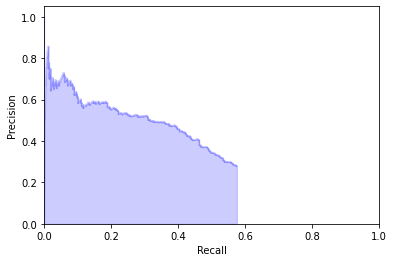

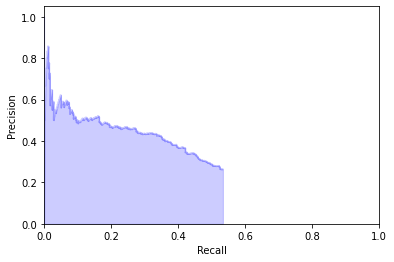

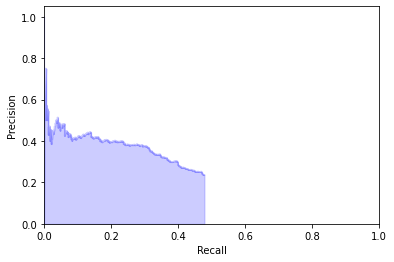

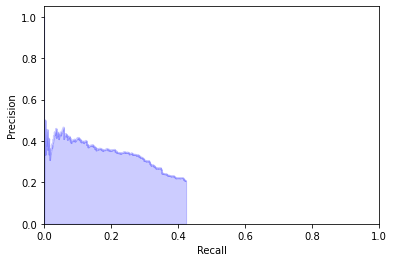

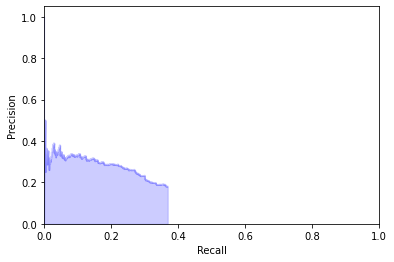

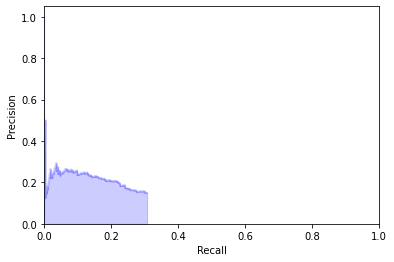

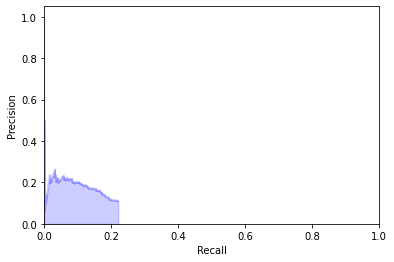

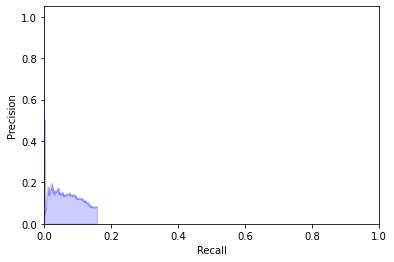

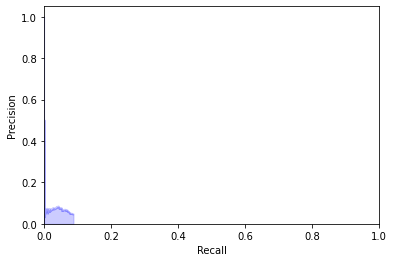

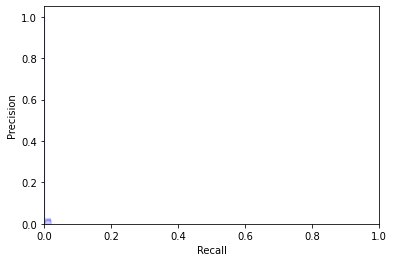

map: 0.11006514654826957


In [47]:
import copy

predictions = []
dev_loader = DataLoader(dataset=dev_dataset, batch_size=4, shuffle=False, num_workers=4)
model.eval()
for img, _, _ in tqdm(dev_loader):
    with torch.no_grad():
        output = model(img.to(device))
    
    for i in range(output[0]['hm'].shape[0]):
        coords = extract_coords((output[0]['hm'][i], output[0]['reg'][i]), threshold1)
        #coords = extract_coords_tmp((output[0]['hm'][i], output[0]['reg'][i]), threshold1, threshold2, threshold3)
        s = coords2str(coords)
        predictions.append(s)
        
df_dev['PredictionString'] = copy.copy(predictions)

valid_df = df_dev
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('../input/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    if np.sum(result_flg) > 0:
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
        print_pr_curve(result_flg, scores, recall)
    else:
        ap = 0
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)

In [48]:
def peak_tmp(array, threshold1, threshold2, threshold3):
    (xlist, ylist) = np.where(array[0]>np.sort(array[0].reshape((1,-1)))[0][-100])
    
    
    
    peak_array = array[0]
    maximum = array.max()
    
    advantage = np.zeros(array[0].shape)
    penalty = np.zeros(array[0].shape)
    
    for k in range(len(xlist)):
        i = xlist[k]
        j = ylist[k]
        ct1 = 0 # 주변의 점들이 top 100 안에 있는가
        ct2 = 0 # 주변의 점들의 값이 더 작은가 
        
        if 0<i<array.shape[1]-1 and 0<j<array.shape[2]-1:    
            surroundings = [(i-1,j+1),(i-1,j),(i-1,j+1),(i,j-1),(i,j+1),(i+1,j+1),(i+1,j),(i+1,j+1)]
            for xy in surroundings:
                if (xy[0], xy[1]) in list(zip(xlist, ylist)):                    
                    ct1 += 1
                if peak_array[i,j] > peak_array[xy[0], xy[1]]:
                    ct2 += 1
            if ct1 > 6 and ct2 > 7:
                advantage[i,j] += min((maximum - peak_array[i,j])*(1/2),2)
    
    
    for i in range(1,array.shape[1]-1):
        for j in range(1,array.shape[2]-1):    
            ct_sur = 0
            ct_vert = 0
            ct_hori = 0
            surroundings = [(i,j),(i,j+1),(i+1,j),(i+1,j+1)]
            horizontal = [(i,j-1),(i,j),(i,j+1)]
            vertical = [(i-1,j),(i,j),(i+1,j)] 
            
            for xy in surroundings:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_sur += 1
                    
            for xy in vertical:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_vert += 1

            for xy in vertical:
                if array[0][xy[0],xy[1]]>threshold1:
                    ct_hori += 1

            if ct_sur > 2:
                idx_small = np.array([array[0][i,j],array[0][i,j+1],array[0][i+1,j],array[0][i+1,j+1]]).argsort()[:2]
                idx_list = [[i,j],[i,j+1],[i+1,j],[i+1,j+1]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

            if ct_vert == 3:
                idx_small = np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]).argsort()[:2]
                idx_list = [[i-1,j],[i,j],[i+1,j]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

            if ct_hori == 3:
                idx_small = np.array([array[0][i-1,j],array[0][i,j],array[0][i+1,j]]).argsort()[:1]
                idx_list = [[i,j-1],[i,j],[i,j+1]]
                for i in idx_small:
                    penalty[idx_list[i][0], idx_list[i][1]] -= 1

    print("advantage:", np.sum(advantage)*threshold2)
    print("penalty:", np.sum(penalty)*threshold3)
    
    
    peak_array = peak_array + advantage*threshold2 + penalty*threshold3
    
    threshold_iter = 0
    while np.sum(peak_array>threshold1)<5 and threshold_iter<8:
        threshold_iter+=1
        peak_array += 0.5
        print("brighter:", np.sum(peak_array>threshold1))
        
        #if idx==1 and array[i,j]>threshold1-3:
        #    peak_array[i,j]+=(maximum - peak_array[i,j])*(2/3)
        #if idx==0 and array[i,j]>threshold1:
        #    peak_array[i,j]+=(maximum - peak_array[i,j])*(2/3)
            
        #if array[i,j]>threshold1+threshold2: #1.5
        #    pass#peak_array[i,j]+=0.5 #1
    return peak_array #, advantage



    
#     plt.figure(figsize=(16,16))
#     plt.title('New')
#     plt.imshow(peak(logits[None],threshold1,threshold2)[0]>-2)
#     plt.show()

In [49]:
print(threshold1)
print(threshold2)
print(threshold3)

-1
0
0.2


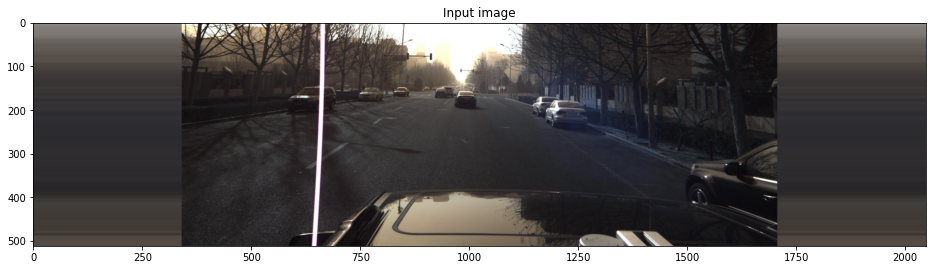

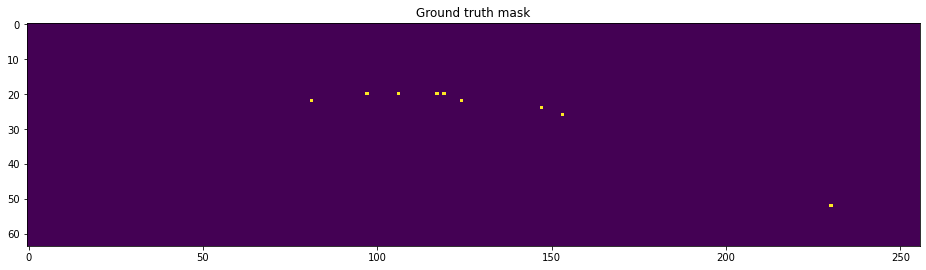

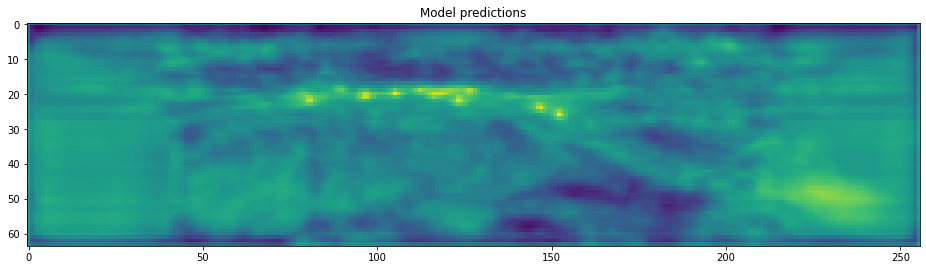

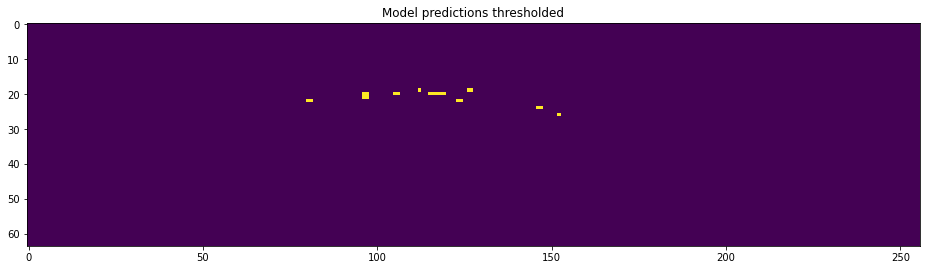

advantage: 0.0
penalty: -0.4


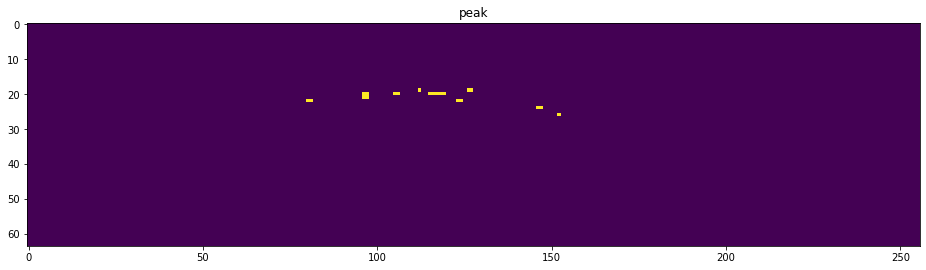

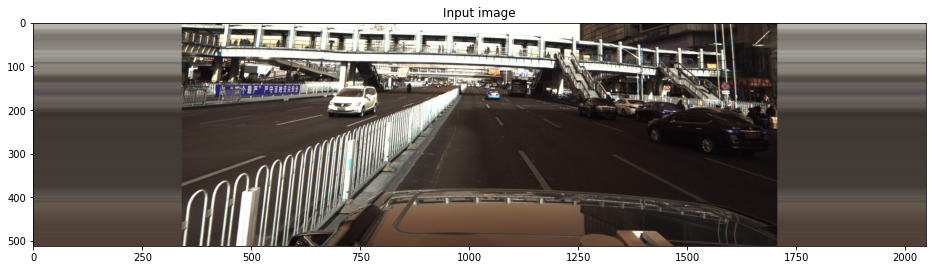

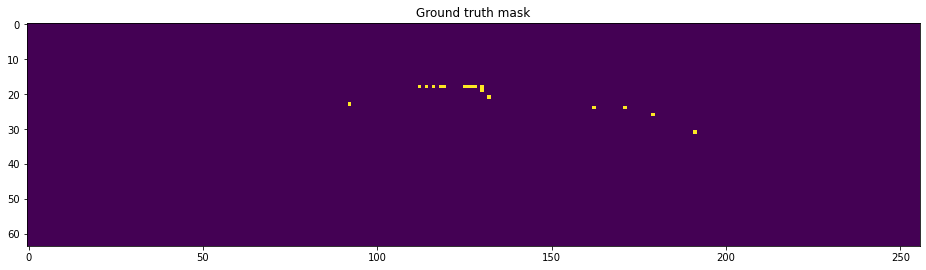

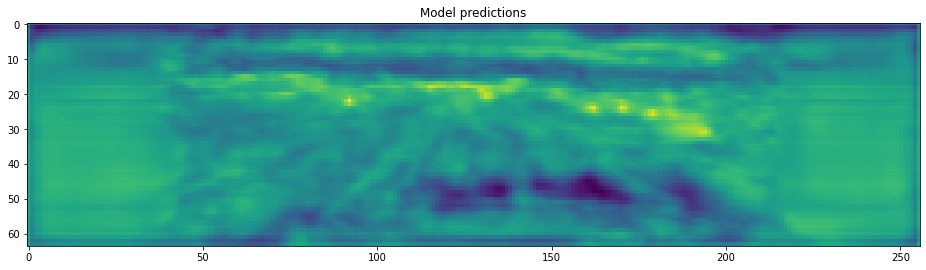

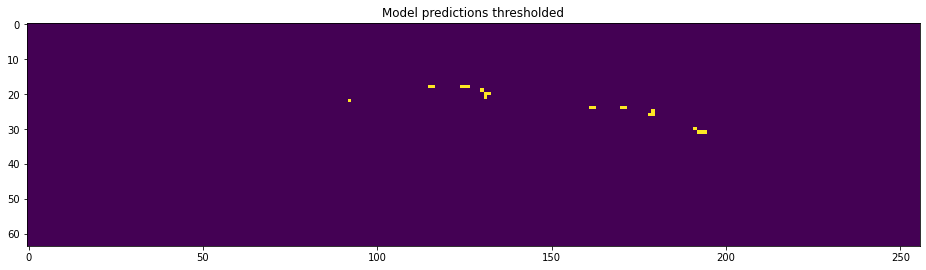

advantage: 0.0
penalty: -0.8


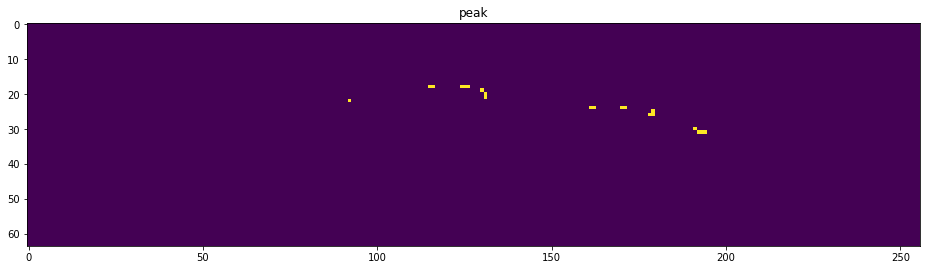

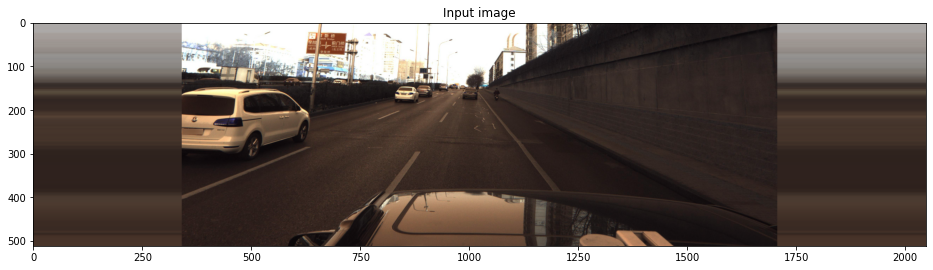

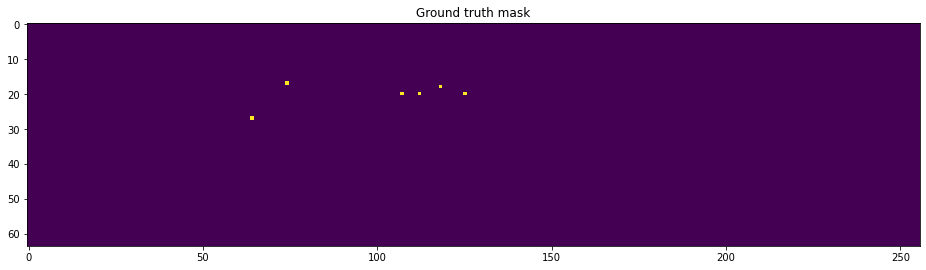

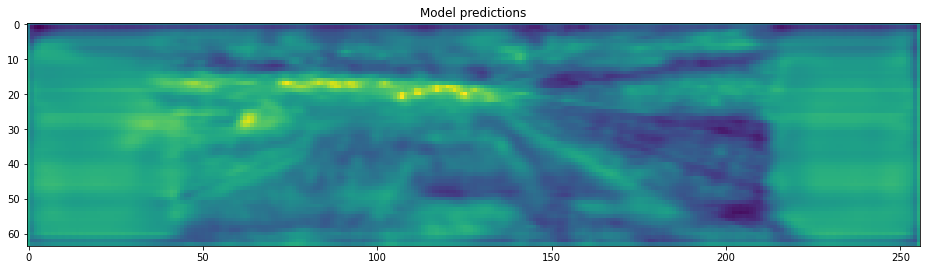

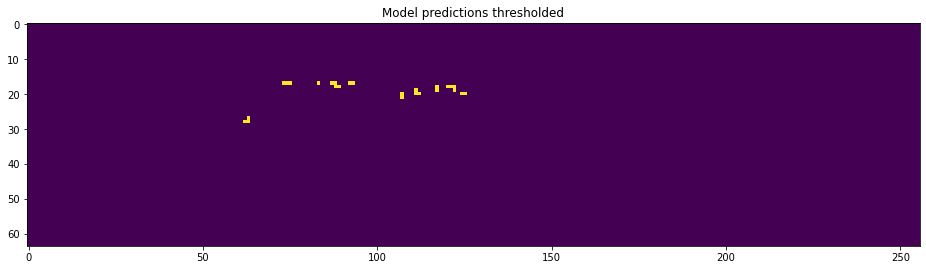

advantage: 0.0
penalty: -1.6


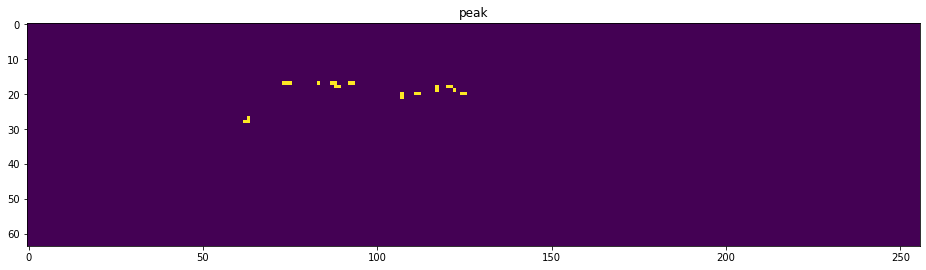

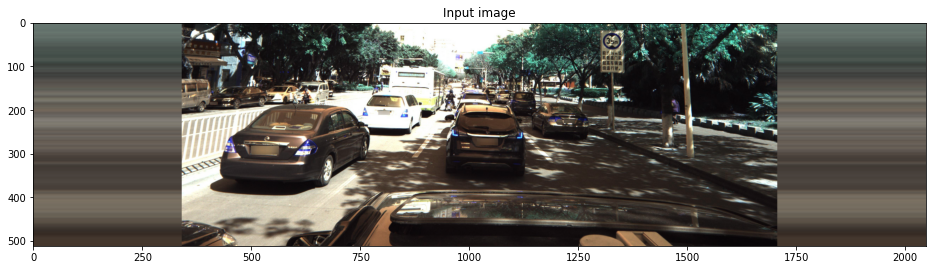

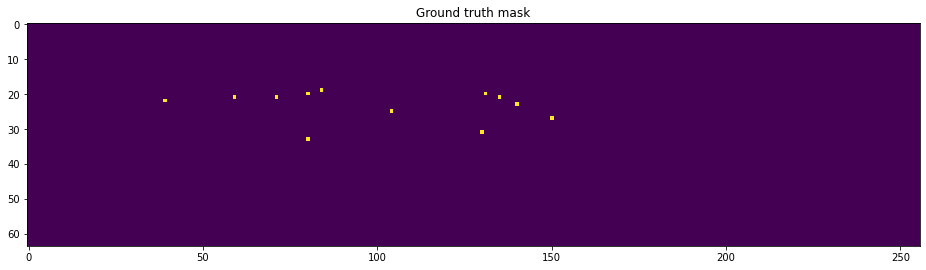

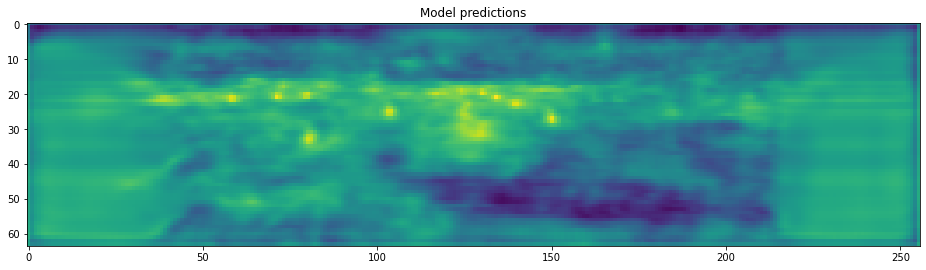

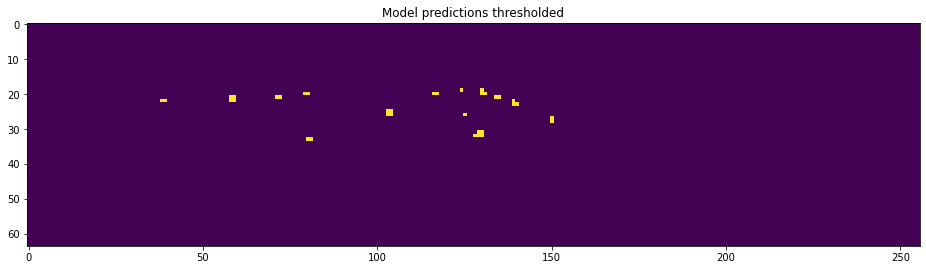

advantage: 0.0
penalty: -2.0


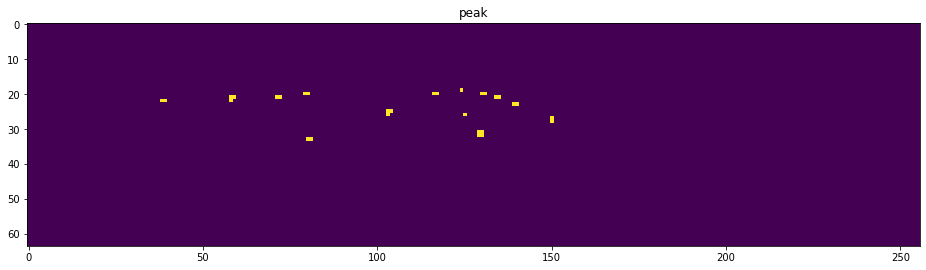

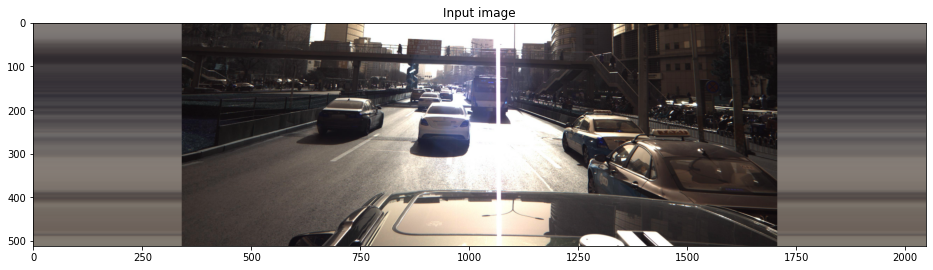

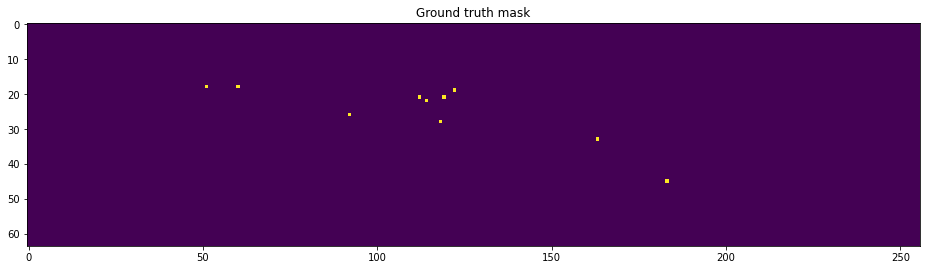

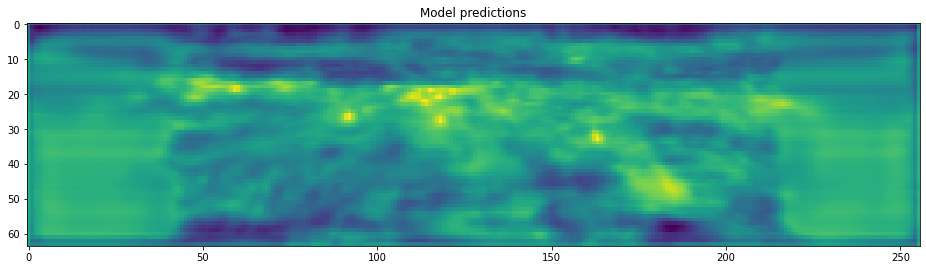

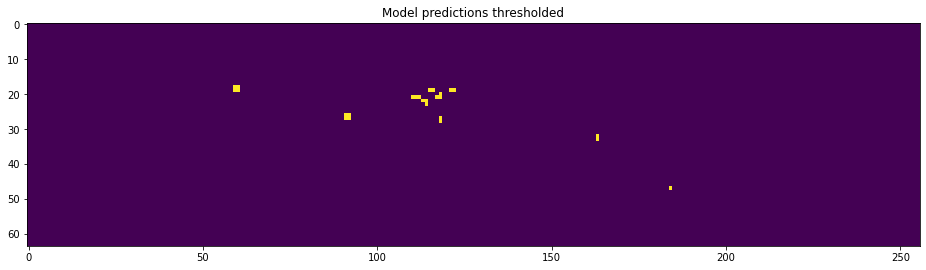

advantage: 0.0
penalty: -1.6


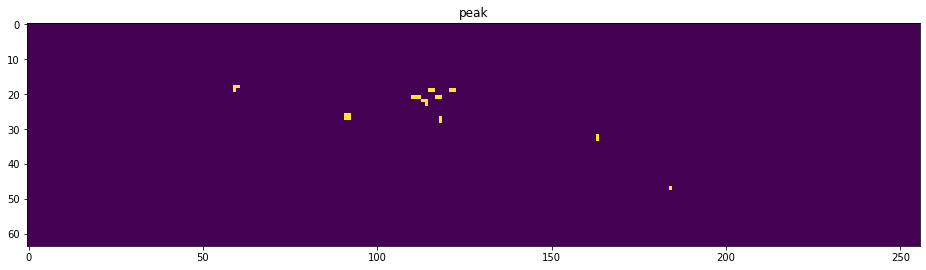

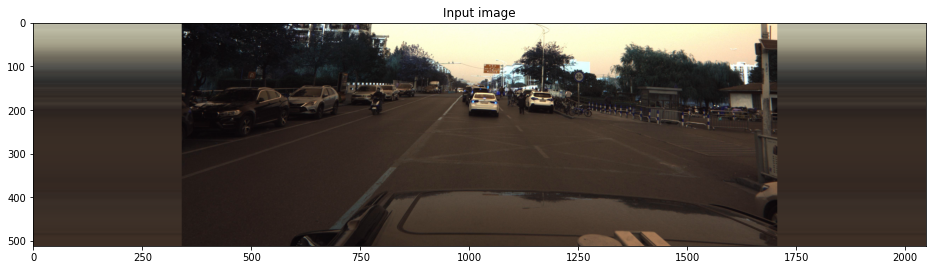

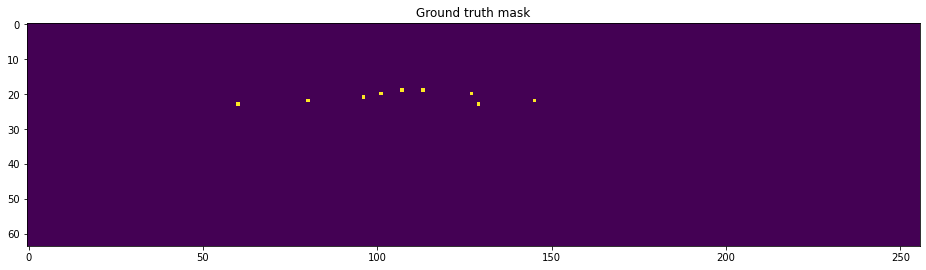

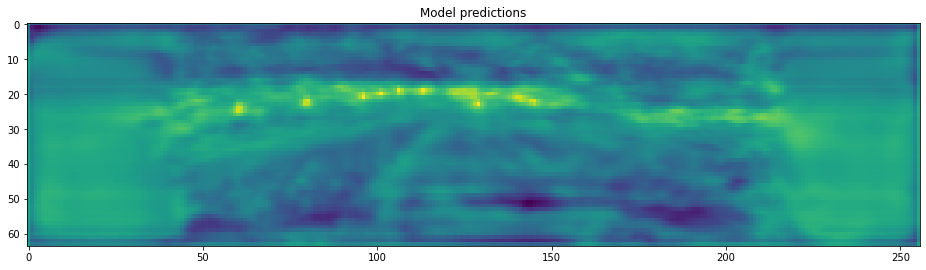

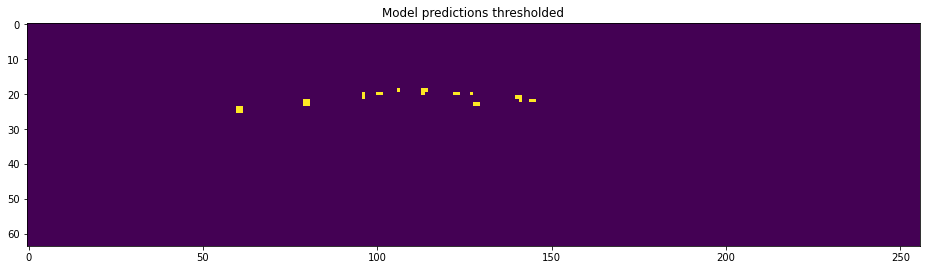

advantage: 0.0
penalty: -1.6


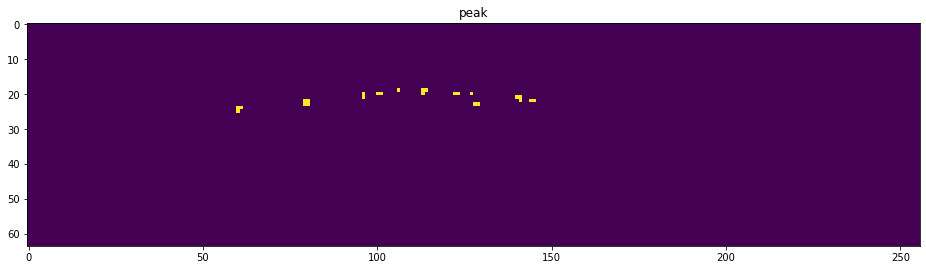

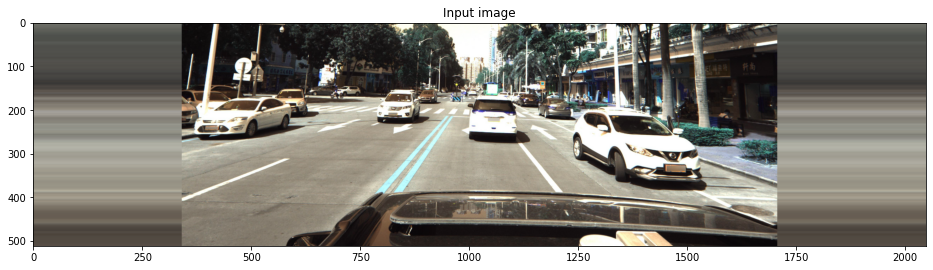

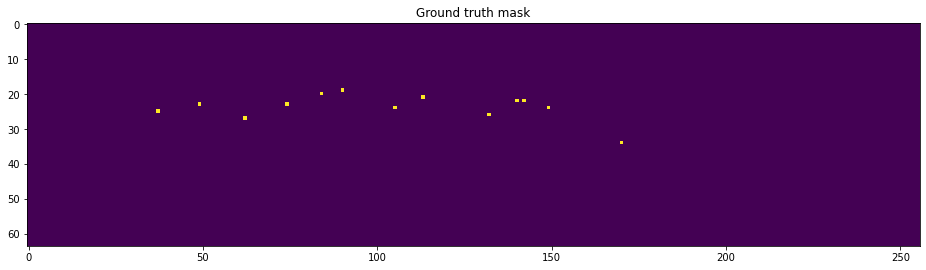

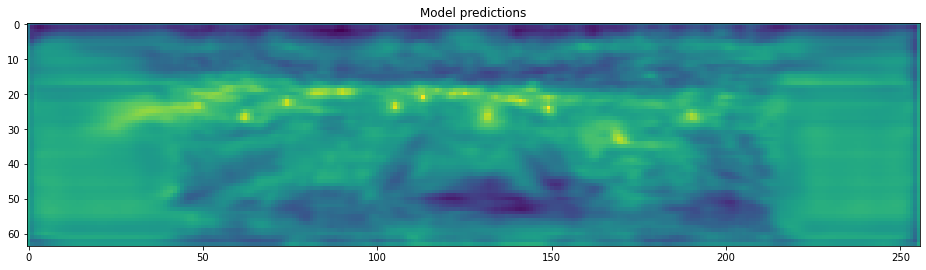

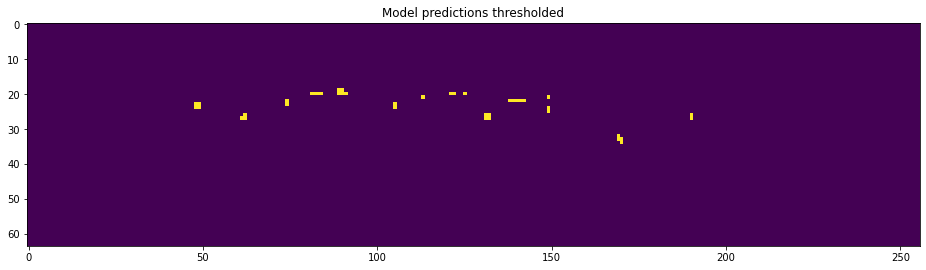

advantage: 0.0
penalty: -2.0


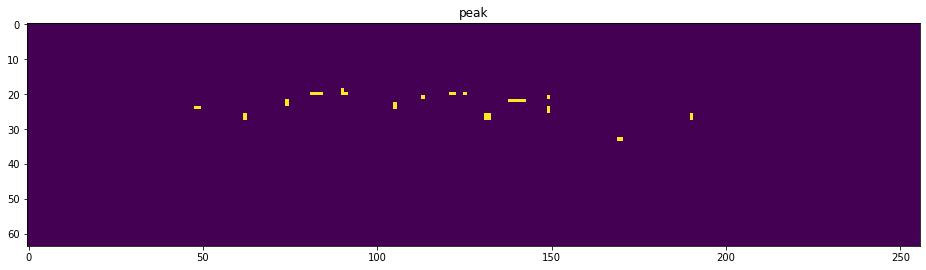

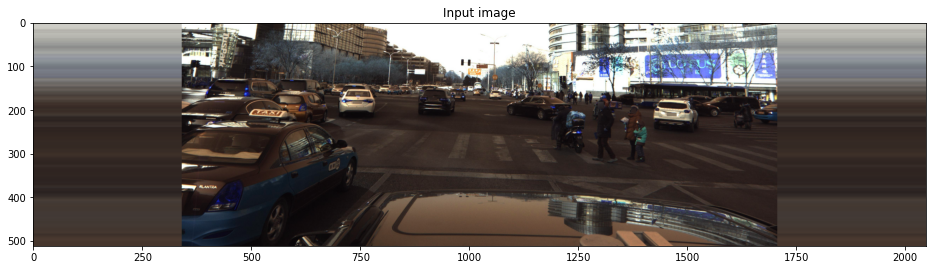

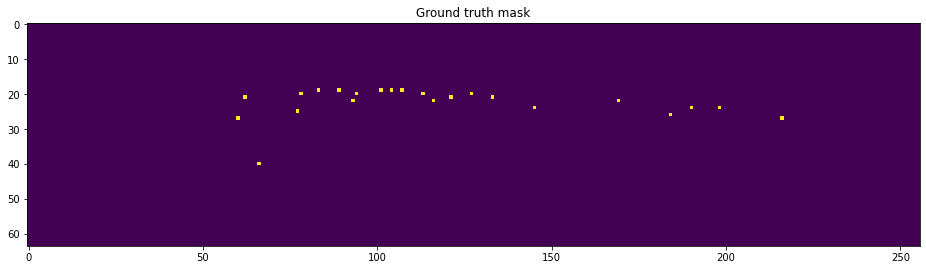

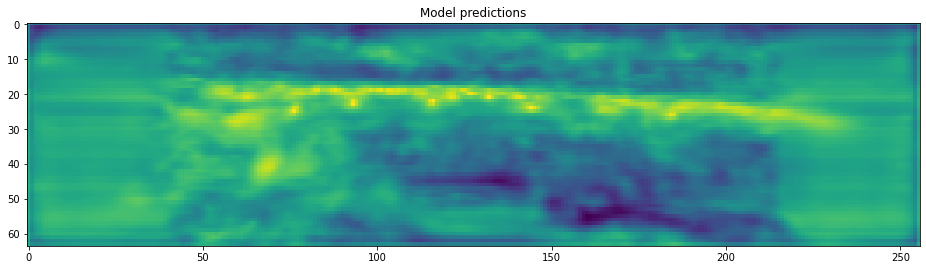

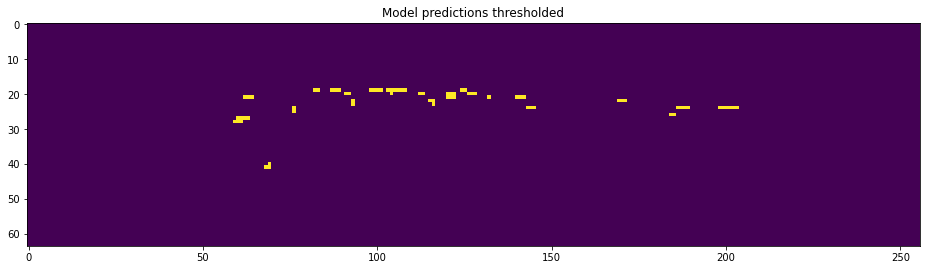

advantage: 0.0
penalty: -2.0


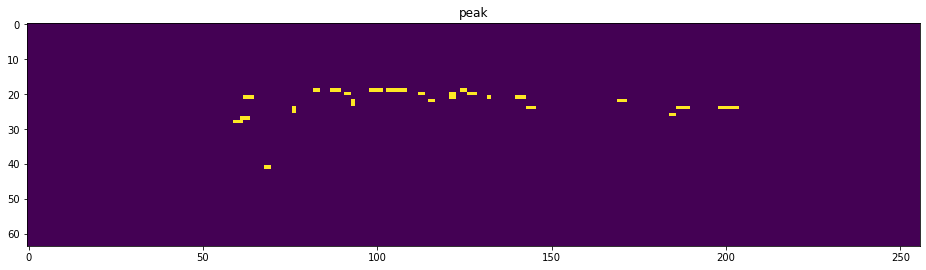

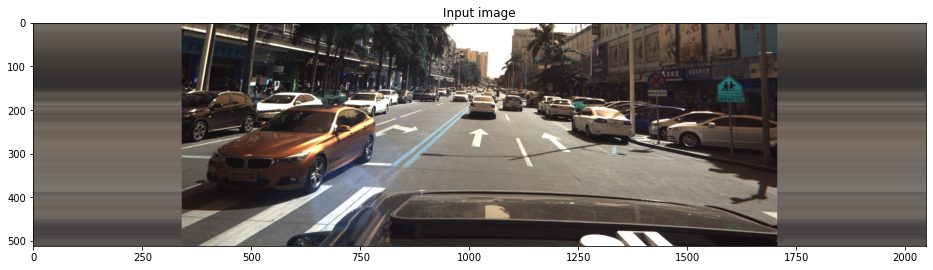

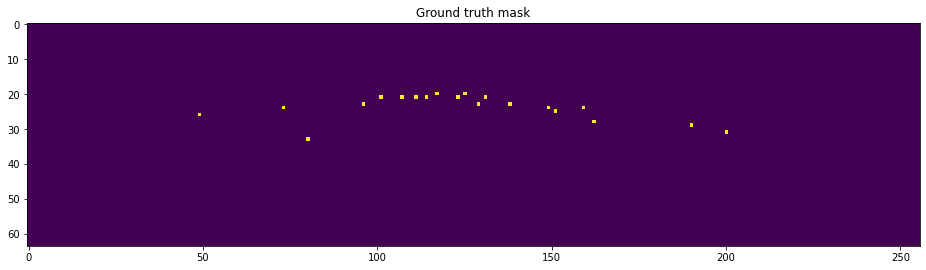

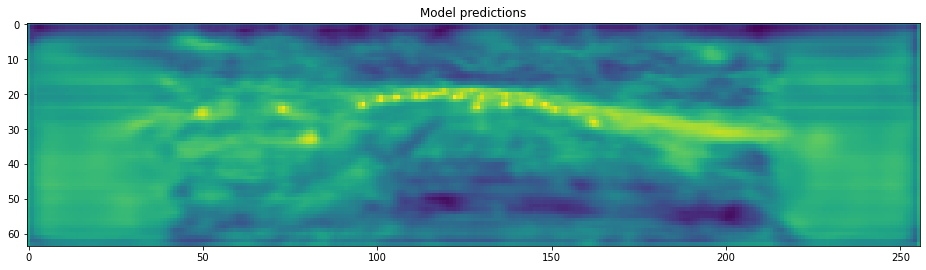

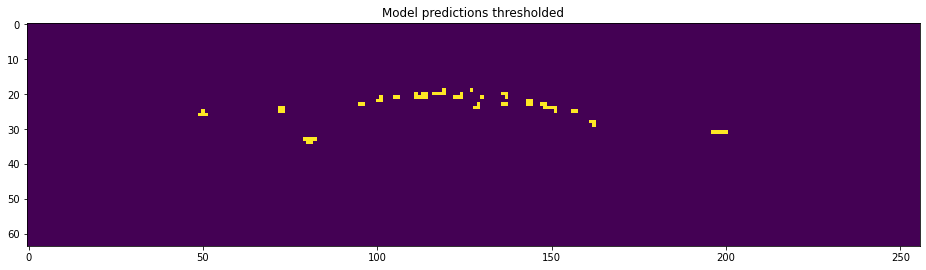

advantage: 0.0
penalty: -3.6


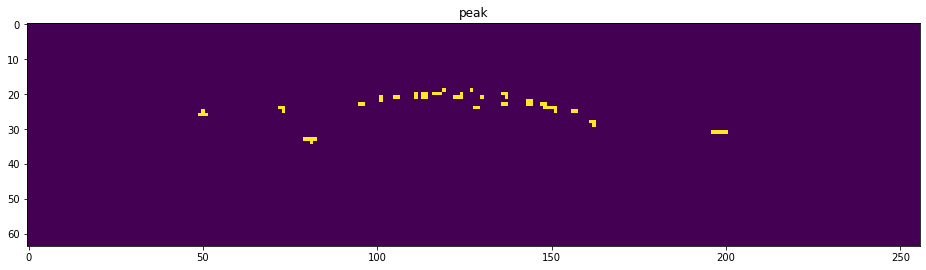

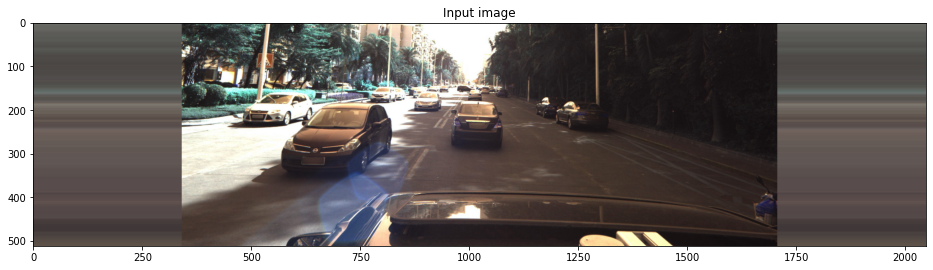

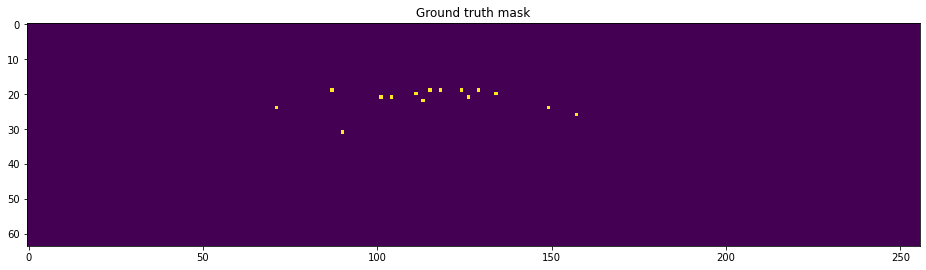

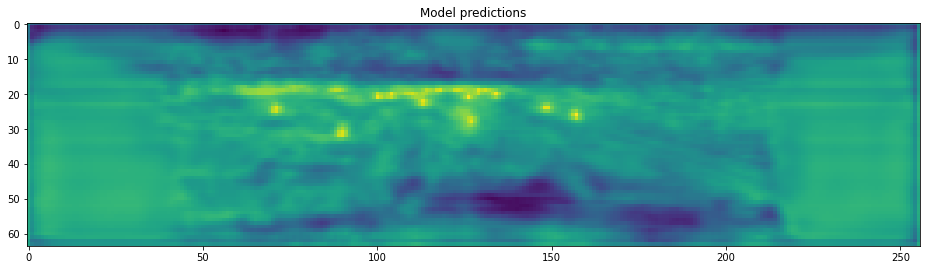

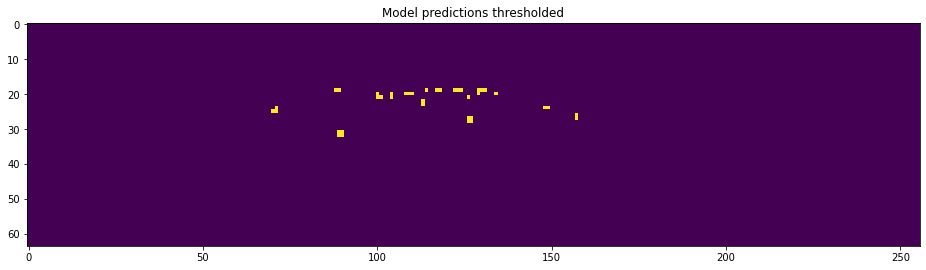

advantage: 0.0
penalty: -2.0


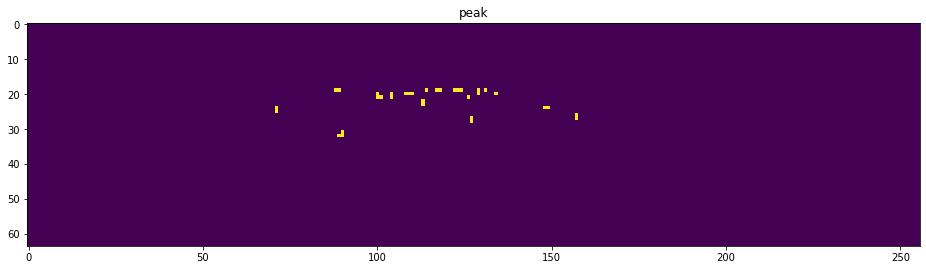

In [50]:
for i in range(40,50):
    img, mask, regr = train_dataset[i]
    plt.figure(figsize=(16,16))
    plt.title('Input image')
    plt.imshow(np.rollaxis(img, 0, 3))
    plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Ground truth mask')
    plt.imshow(mask)
    plt.show()
    
    output = model(torch.tensor(img[None]).to(device))
    output = output[0]['hm']
    logits = output[0,0].data.cpu().numpy()

    plt.figure(figsize=(16,16))
    plt.title('Model predictions')
    plt.imshow(logits)
    plt.show()

    plt.figure(figsize=(16,16))
    plt.title('Model predictions thresholded')
    plt.imshow(logits>-1)
    plt.show()
    
    img = peak_tmp(output[0].detach().cpu().numpy(),threshold1,threshold2,threshold3)
    plt.figure(figsize=(16,16))
    plt.title('peak')
    plt.imshow(img>-1)
    plt.show()
    
#     img = peak(output[0].detach(),threshold1)
#     plt.figure(figsize=(16,16))
#     plt.title('peak')
#     plt.imshow(img>-2)
#     plt.show()


# Make submission

In [51]:
def show_coords(prediction, threshold1, threshold2, threshold3):
    #logits = peak(prediction[0], threshold1) 
    #logits = prediction[0][0].cpu().numpy()
    logits = peak_tmp(output[0].detach().cpu().numpy(),threshold1,threshold2, threshold3)
    plt.figure(figsize=(12, 8))
    plt.imshow(logits)
    plt.show()

    regr_output = prediction[1:]
    plt.figure(figsize=(12, 8))
    plt.imshow(logits > threshold1)
    plt.show()

# Show prediction results

In [52]:
# threshold1 = -1
# predictions = []

# test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)
# model.eval()

# for img, _, _ in tqdm(test_loader):
    
#     plt.figure(figsize=(12, 8))
#     plt.imshow(np.einsum('ijk->jki', img[0]))
#     plt.show()
    
#     with torch.no_grad():
#         output = model(img.to(device))
#     output = output[0]['hm']
#     show_coords(output,threshold1, threshold2, threshold3)
        

# Submission

In [53]:
predictions = []
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)
model.eval()
plot = False
for img, _, _ in tqdm(test_loader):
    idx = 0
    with torch.no_grad():
        output = model(img.to(device))
    for i in range(output[0]['hm'].shape[0]):
        coords = extract_coords_tmp((output[0]['hm'][i], output[0]['reg'][i]),threshold1, threshold2, threshold3)
        s = coords2str(coords)
        predictions.append(s)
        
        if plot == True:
            plt.figure(figsize=(15, 8))
            plt.imshow(np.einsum('ijk->jki', img[idx]))
            plt.show()

        idx += 1
        
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('Prediction-dla34-G_2-F-aug'+'_'+str(threshold1)+'_'+str(threshold2)+'_' \
            +str(threshold3)+ '.csv', index=False)
test.head()

  0%|          | 0/506 [00:00<?, ?it/s]

advantage: 0.0
penalty: 0.0
brighter: 3
brighter: 7
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


  0%|          | 1/506 [00:04<34:39,  4.12s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


  0%|          | 2/506 [00:06<30:07,  3.59s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


  1%|          | 3/506 [00:09<27:27,  3.27s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4


  1%|          | 4/506 [00:11<25:07,  3.00s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


  1%|          | 5/506 [00:14<24:29,  2.93s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


  1%|          | 6/506 [00:16<23:58,  2.88s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003


  1%|▏         | 7/506 [00:19<23:48,  2.86s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003


  2%|▏         | 8/506 [00:22<23:30,  2.83s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


  2%|▏         | 9/506 [00:25<22:45,  2.75s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


  2%|▏         | 10/506 [00:27<21:36,  2.61s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
brighter: 11
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.8000000000000003


  2%|▏         | 11/506 [00:30<21:46,  2.64s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


  2%|▏         | 12/506 [00:32<22:13,  2.70s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


  3%|▎         | 13/506 [00:35<22:05,  2.69s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6


  3%|▎         | 14/506 [00:37<21:06,  2.58s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


  3%|▎         | 15/506 [00:40<21:23,  2.61s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


  3%|▎         | 16/506 [00:42<20:52,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0


  3%|▎         | 17/506 [00:45<20:52,  2.56s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002


  4%|▎         | 18/506 [00:47<20:20,  2.50s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


  4%|▍         | 19/506 [00:50<20:05,  2.48s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


  4%|▍         | 20/506 [00:53<20:43,  2.56s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


  4%|▍         | 21/506 [00:55<20:21,  2.52s/it]

advantage: 0.0
penalty: -0.4
brighter: 9
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


  4%|▍         | 22/506 [00:57<20:02,  2.48s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


  5%|▍         | 23/506 [01:00<19:45,  2.46s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


  5%|▍         | 24/506 [01:02<19:34,  2.44s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


  5%|▍         | 25/506 [01:05<20:05,  2.51s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


  5%|▌         | 26/506 [01:08<20:26,  2.55s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


  5%|▌         | 27/506 [01:10<20:39,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0
brighter: 8
advantage: 0.0
penalty: -0.4


  6%|▌         | 28/506 [01:13<20:05,  2.52s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


  6%|▌         | 29/506 [01:15<20:09,  2.53s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


  6%|▌         | 30/506 [01:18<20:31,  2.59s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


  6%|▌         | 31/506 [01:20<20:06,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004


  6%|▋         | 32/506 [01:23<20:03,  2.54s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


  7%|▋         | 33/506 [01:26<21:05,  2.68s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


  7%|▋         | 34/506 [01:28<20:45,  2.64s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -1.2000000000000002


  7%|▋         | 35/506 [01:31<20:49,  2.65s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


  7%|▋         | 36/506 [01:34<20:29,  2.62s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


  7%|▋         | 37/506 [01:36<20:09,  2.58s/it]

advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


  8%|▊         | 38/506 [01:39<20:27,  2.62s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


  8%|▊         | 39/506 [01:41<19:56,  2.56s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6


  8%|▊         | 40/506 [01:44<19:30,  2.51s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004


  8%|▊         | 41/506 [01:46<19:42,  2.54s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


  8%|▊         | 42/506 [01:49<19:41,  2.55s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
brighter: 5
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


  8%|▊         | 43/506 [01:51<19:50,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


  9%|▊         | 44/506 [01:54<19:56,  2.59s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.2


  9%|▉         | 45/506 [01:57<19:56,  2.60s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.6


  9%|▉         | 46/506 [01:59<20:11,  2.63s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


  9%|▉         | 47/506 [02:02<19:54,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.2


  9%|▉         | 48/506 [02:04<19:45,  2.59s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0


 10%|▉         | 49/506 [02:07<20:28,  2.69s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 10%|▉         | 50/506 [02:10<20:40,  2.72s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002


 10%|█         | 51/506 [02:12<19:41,  2.60s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 10%|█         | 52/506 [02:15<19:25,  2.57s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0


 10%|█         | 53/506 [02:18<19:22,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


 11%|█         | 54/506 [02:20<19:36,  2.60s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


 11%|█         | 55/506 [02:23<19:26,  2.59s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 11%|█         | 56/506 [02:25<18:50,  2.51s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 11%|█▏        | 57/506 [02:28<18:41,  2.50s/it]

advantage: 0.0
penalty: -1.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 11%|█▏        | 58/506 [02:30<18:45,  2.51s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -0.8


 12%|█▏        | 59/506 [02:32<18:12,  2.44s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 12%|█▏        | 60/506 [02:35<19:03,  2.56s/it]

advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002


 12%|█▏        | 61/506 [02:38<19:39,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 12%|█▏        | 62/506 [02:41<19:34,  2.64s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 12%|█▏        | 63/506 [02:43<18:53,  2.56s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0


 13%|█▎        | 64/506 [02:46<18:38,  2.53s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


 13%|█▎        | 65/506 [02:48<18:35,  2.53s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 13%|█▎        | 66/506 [02:51<19:43,  2.69s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.2


 13%|█▎        | 67/506 [02:54<19:48,  2.71s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -2.8000000000000003


 13%|█▎        | 68/506 [02:57<19:53,  2.72s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.0


 14%|█▎        | 69/506 [02:59<19:53,  2.73s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0


 14%|█▍        | 70/506 [03:02<19:51,  2.73s/it]

advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4


 14%|█▍        | 71/506 [03:05<19:38,  2.71s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.4000000000000004


 14%|█▍        | 72/506 [03:08<20:00,  2.77s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


 14%|█▍        | 73/506 [03:10<19:47,  2.74s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 15%|█▍        | 74/506 [03:13<19:26,  2.70s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8


 15%|█▍        | 75/506 [03:16<19:23,  2.70s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 15%|█▌        | 76/506 [03:18<18:55,  2.64s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 15%|█▌        | 77/506 [03:21<18:22,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 15%|█▌        | 78/506 [03:23<17:45,  2.49s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 16%|█▌        | 79/506 [03:25<17:29,  2.46s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -3.6
advantage: 0.0
penalty: -2.2


 16%|█▌        | 80/506 [03:28<18:09,  2.56s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


 16%|█▌        | 81/506 [03:31<18:01,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.2


 16%|█▌        | 82/506 [03:33<18:14,  2.58s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0


 16%|█▋        | 83/506 [03:36<17:58,  2.55s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -0.8


 17%|█▋        | 84/506 [03:38<17:59,  2.56s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8


 17%|█▋        | 85/506 [03:41<17:56,  2.56s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.6


 17%|█▋        | 86/506 [03:44<18:40,  2.67s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.6


 17%|█▋        | 87/506 [03:46<18:14,  2.61s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0


 17%|█▋        | 88/506 [03:49<18:17,  2.63s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 18%|█▊        | 89/506 [03:51<17:45,  2.56s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4


 18%|█▊        | 90/506 [03:54<17:38,  2.55s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 18%|█▊        | 91/506 [03:56<17:29,  2.53s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


 18%|█▊        | 92/506 [03:59<18:08,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


 18%|█▊        | 93/506 [04:02<18:07,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.8


 19%|█▊        | 94/506 [04:05<18:33,  2.70s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0


 19%|█▉        | 95/506 [04:07<17:47,  2.60s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003


 19%|█▉        | 96/506 [04:10<18:03,  2.64s/it]

advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003


 19%|█▉        | 97/506 [04:13<18:22,  2.70s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004


 19%|█▉        | 98/506 [04:15<18:03,  2.66s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 20%|█▉        | 99/506 [04:18<17:56,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4


 20%|█▉        | 100/506 [04:20<17:05,  2.53s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 20%|█▉        | 101/506 [04:23<17:15,  2.56s/it]

advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -3.4000000000000004
advantage: 0.0
penalty: -1.8


 20%|██        | 102/506 [04:26<18:14,  2.71s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.4000000000000001


 20%|██        | 103/506 [04:28<17:33,  2.61s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.2


 21%|██        | 104/506 [04:31<17:26,  2.60s/it]

advantage: 0.0
penalty: -3.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 21%|██        | 105/506 [04:33<17:06,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.4000000000000001
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 21%|██        | 106/506 [04:36<16:56,  2.54s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 21%|██        | 107/506 [04:38<17:18,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.4000000000000004
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


 21%|██▏       | 108/506 [04:41<17:29,  2.64s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0


 22%|██▏       | 109/506 [04:44<17:41,  2.67s/it]

advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 22%|██▏       | 110/506 [04:47<17:45,  2.69s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.4000000000000001


 22%|██▏       | 111/506 [04:49<17:38,  2.68s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0
brighter: 5
advantage: 0.0
penalty: -0.4


 22%|██▏       | 112/506 [04:51<16:41,  2.54s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0


 22%|██▏       | 113/506 [04:54<16:27,  2.51s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 23%|██▎       | 114/506 [04:57<16:37,  2.54s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 23%|██▎       | 115/506 [04:59<16:26,  2.52s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 23%|██▎       | 116/506 [05:01<16:10,  2.49s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002


 23%|██▎       | 117/506 [05:04<16:15,  2.51s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


 23%|██▎       | 118/506 [05:07<16:18,  2.52s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 24%|██▎       | 119/506 [05:09<16:48,  2.60s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002


 24%|██▎       | 120/506 [05:12<16:55,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 24%|██▍       | 121/506 [05:14<16:27,  2.57s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 24%|██▍       | 122/506 [05:17<16:42,  2.61s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.4000000000000001
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


 24%|██▍       | 123/506 [05:20<16:49,  2.63s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 25%|██▍       | 124/506 [05:23<17:18,  2.72s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 25%|██▍       | 125/506 [05:25<17:14,  2.72s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 25%|██▍       | 126/506 [05:28<17:01,  2.69s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 25%|██▌       | 127/506 [05:31<16:42,  2.64s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 25%|██▌       | 128/506 [05:33<16:28,  2.62s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 25%|██▌       | 129/506 [05:36<15:59,  2.55s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 26%|██▌       | 130/506 [05:38<15:47,  2.52s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -1.2000000000000002


 26%|██▌       | 131/506 [05:41<16:36,  2.66s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 26%|██▌       | 132/506 [05:44<16:34,  2.66s/it]

advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 26%|██▋       | 133/506 [05:46<16:31,  2.66s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 26%|██▋       | 134/506 [05:49<16:16,  2.63s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -3.8000000000000003


 27%|██▋       | 135/506 [05:51<16:05,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 27%|██▋       | 136/506 [05:54<16:07,  2.62s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.6
advantage: 0.0
penalty: -1.6


 27%|██▋       | 137/506 [05:57<16:16,  2.65s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004


 27%|██▋       | 138/506 [06:00<16:27,  2.68s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 27%|██▋       | 139/506 [06:02<15:54,  2.60s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 28%|██▊       | 140/506 [06:05<16:07,  2.64s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


 28%|██▊       | 141/506 [06:07<16:12,  2.66s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 28%|██▊       | 142/506 [06:10<15:48,  2.61s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002


 28%|██▊       | 143/506 [06:12<15:38,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 28%|██▊       | 144/506 [06:15<15:34,  2.58s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 29%|██▊       | 145/506 [06:18<15:34,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 29%|██▉       | 146/506 [06:20<15:33,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.2000000000000002


 29%|██▉       | 147/506 [06:23<15:20,  2.56s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 29%|██▉       | 148/506 [06:25<15:37,  2.62s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 29%|██▉       | 149/506 [06:28<15:26,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 30%|██▉       | 150/506 [06:30<15:07,  2.55s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4


 30%|██▉       | 151/506 [06:33<14:59,  2.53s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0


 30%|███       | 152/506 [06:36<15:38,  2.65s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -1.2000000000000002


 30%|███       | 153/506 [06:39<15:40,  2.66s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 30%|███       | 154/506 [06:41<15:30,  2.64s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -1.2000000000000002


 31%|███       | 155/506 [06:44<14:59,  2.56s/it]

advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 31%|███       | 156/506 [06:46<14:57,  2.56s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


 31%|███       | 157/506 [06:49<15:07,  2.60s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4


 31%|███       | 158/506 [06:51<14:53,  2.57s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003


 31%|███▏      | 159/506 [06:54<15:25,  2.67s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 32%|███▏      | 160/506 [06:56<14:45,  2.56s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 32%|███▏      | 161/506 [06:59<14:27,  2.51s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
brighter: 4
brighter: 8


 32%|███▏      | 162/506 [07:01<14:07,  2.46s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 32%|███▏      | 163/506 [07:04<13:58,  2.44s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 32%|███▏      | 164/506 [07:06<13:49,  2.43s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
brighter: 6


 33%|███▎      | 165/506 [07:09<14:06,  2.48s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 33%|███▎      | 166/506 [07:11<14:00,  2.47s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 33%|███▎      | 167/506 [07:13<13:49,  2.45s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
brighter: 1
brighter: 3
brighter: 14


 33%|███▎      | 168/506 [07:16<14:20,  2.54s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 33%|███▎      | 169/506 [07:19<13:57,  2.48s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 34%|███▎      | 170/506 [07:21<13:50,  2.47s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8


 34%|███▍      | 171/506 [07:23<13:34,  2.43s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003


 34%|███▍      | 172/506 [07:26<13:59,  2.51s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.0


 34%|███▍      | 173/506 [07:28<13:42,  2.47s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4


 34%|███▍      | 174/506 [07:31<13:51,  2.50s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 35%|███▍      | 175/506 [07:34<13:56,  2.53s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 35%|███▍      | 176/506 [07:36<14:12,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 35%|███▍      | 177/506 [07:39<14:02,  2.56s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0


 35%|███▌      | 178/506 [07:41<13:53,  2.54s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 35%|███▌      | 179/506 [07:44<13:33,  2.49s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 36%|███▌      | 180/506 [07:46<13:38,  2.51s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.6
advantage: 0.0
penalty: -1.6


 36%|███▌      | 181/506 [07:49<14:03,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.0


 36%|███▌      | 182/506 [07:52<14:43,  2.73s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0


 36%|███▌      | 183/506 [07:54<14:09,  2.63s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 36%|███▋      | 184/506 [07:57<13:44,  2.56s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -2.0


 37%|███▋      | 185/506 [08:00<13:55,  2.60s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
brighter: 5


 37%|███▋      | 186/506 [08:02<13:22,  2.51s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 37%|███▋      | 187/506 [08:04<13:28,  2.53s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.4000000000000004


 37%|███▋      | 188/506 [08:07<13:40,  2.58s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 37%|███▋      | 189/506 [08:10<13:19,  2.52s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 38%|███▊      | 190/506 [08:12<13:43,  2.61s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 38%|███▊      | 191/506 [08:15<13:27,  2.56s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.4000000000000004


 38%|███▊      | 192/506 [08:18<14:06,  2.70s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -3.4000000000000004
advantage: 0.0
penalty: -3.2


 38%|███▊      | 193/506 [08:21<14:32,  2.79s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


 38%|███▊      | 194/506 [08:24<14:24,  2.77s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0


 39%|███▊      | 195/506 [08:26<13:54,  2.68s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4


 39%|███▊      | 196/506 [08:29<13:41,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -3.2


 39%|███▉      | 197/506 [08:31<13:39,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 39%|███▉      | 198/506 [08:34<13:17,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 39%|███▉      | 199/506 [08:36<13:21,  2.61s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 40%|███▉      | 200/506 [08:39<13:04,  2.56s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0


 40%|███▉      | 201/506 [08:41<12:43,  2.50s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003


 40%|███▉      | 202/506 [08:44<13:00,  2.57s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 40%|████      | 203/506 [08:46<12:41,  2.51s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 40%|████      | 204/506 [08:49<12:27,  2.47s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -0.4


 41%|████      | 205/506 [08:51<12:49,  2.56s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 41%|████      | 206/506 [08:54<12:43,  2.54s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -3.8000000000000003


 41%|████      | 207/506 [08:57<13:03,  2.62s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4


 41%|████      | 208/506 [08:59<12:27,  2.51s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.8


 41%|████▏     | 209/506 [09:02<12:40,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.8


 42%|████▏     | 210/506 [09:04<12:56,  2.62s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.0


 42%|████▏     | 211/506 [09:07<13:10,  2.68s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.6


 42%|████▏     | 212/506 [09:10<13:17,  2.71s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


 42%|████▏     | 213/506 [09:12<12:50,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.8000000000000003


 42%|████▏     | 214/506 [09:15<12:58,  2.67s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


 42%|████▏     | 215/506 [09:18<12:30,  2.58s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 43%|████▎     | 216/506 [09:20<12:01,  2.49s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6


 43%|████▎     | 217/506 [09:22<12:13,  2.54s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 43%|████▎     | 218/506 [09:25<12:12,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -4.0
advantage: 0.0
penalty: -0.4


 43%|████▎     | 219/506 [09:28<12:03,  2.52s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 43%|████▎     | 220/506 [09:30<11:57,  2.51s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 44%|████▎     | 221/506 [09:33<12:16,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


 44%|████▍     | 222/506 [09:35<12:15,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.8000000000000003


 44%|████▍     | 223/506 [09:38<12:32,  2.66s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4


 44%|████▍     | 224/506 [09:41<12:04,  2.57s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 44%|████▍     | 225/506 [09:43<11:48,  2.52s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.8


 45%|████▍     | 226/506 [09:46<12:15,  2.63s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 45%|████▍     | 227/506 [09:48<12:07,  2.61s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.4
brighter: 9
advantage: 0.0
penalty: -2.8000000000000003


 45%|████▌     | 228/506 [09:51<12:13,  2.64s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 45%|████▌     | 229/506 [09:54<12:03,  2.61s/it]

advantage: 0.0
penalty: 0.0
brighter: 27
advantage: 0.0
penalty: -1.0
advantage: 0.0
penalty: -1.2000000000000002


 45%|████▌     | 230/506 [09:56<11:45,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 46%|████▌     | 231/506 [09:59<11:34,  2.53s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -1.6


 46%|████▌     | 232/506 [10:01<11:59,  2.62s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 46%|████▌     | 233/506 [10:04<11:59,  2.63s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 46%|████▌     | 234/506 [10:06<11:32,  2.55s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -3.6
advantage: 0.0
penalty: -0.8


 46%|████▋     | 235/506 [10:09<11:54,  2.64s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
brighter: 0
brighter: 22
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -3.4000000000000004


 47%|████▋     | 236/506 [10:12<11:59,  2.66s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003


 47%|████▋     | 237/506 [10:15<11:55,  2.66s/it]

advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 47%|████▋     | 238/506 [10:17<11:59,  2.69s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0


 47%|████▋     | 239/506 [10:20<11:46,  2.65s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4


 47%|████▋     | 240/506 [10:22<11:21,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002


 48%|████▊     | 241/506 [10:25<11:14,  2.55s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.2000000000000002


 48%|████▊     | 242/506 [10:28<11:32,  2.62s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 48%|████▊     | 243/506 [10:30<11:29,  2.62s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0


 48%|████▊     | 244/506 [10:33<11:03,  2.53s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.0


 48%|████▊     | 245/506 [10:35<11:04,  2.55s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 49%|████▊     | 246/506 [10:38<10:57,  2.53s/it]

advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 49%|████▉     | 247/506 [10:40<11:09,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


 49%|████▉     | 248/506 [10:43<10:45,  2.50s/it]

advantage: 0.0
penalty: -1.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.2000000000000002


 49%|████▉     | 249/506 [10:45<10:52,  2.54s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0


 49%|████▉     | 250/506 [10:48<10:35,  2.48s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 50%|████▉     | 251/506 [10:50<10:22,  2.44s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 50%|████▉     | 252/506 [10:52<10:27,  2.47s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 50%|█████     | 253/506 [10:55<10:21,  2.46s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0


 50%|█████     | 254/506 [10:58<10:29,  2.50s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 50%|█████     | 255/506 [11:00<10:44,  2.57s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003


 51%|█████     | 256/506 [11:03<10:55,  2.62s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 51%|█████     | 257/506 [11:05<10:38,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 51%|█████     | 258/506 [11:08<10:39,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0


 51%|█████     | 259/506 [11:10<10:24,  2.53s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.6


 51%|█████▏    | 260/506 [11:13<10:26,  2.55s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 52%|█████▏    | 261/506 [11:16<10:41,  2.62s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4


 52%|█████▏    | 262/506 [11:18<10:19,  2.54s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 52%|█████▏    | 263/506 [11:21<10:19,  2.55s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.8


 52%|█████▏    | 264/506 [11:23<10:15,  2.54s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
brighter: 5
advantage: 0.0
penalty: -3.6


 52%|█████▏    | 265/506 [11:26<10:10,  2.53s/it]

advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 53%|█████▎    | 266/506 [11:28<10:13,  2.56s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 53%|█████▎    | 267/506 [11:31<10:11,  2.56s/it]

advantage: 0.0
penalty: -1.4000000000000001
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003


 53%|█████▎    | 268/506 [11:34<10:24,  2.62s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 53%|█████▎    | 269/506 [11:37<10:38,  2.69s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 53%|█████▎    | 270/506 [11:39<10:25,  2.65s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 54%|█████▎    | 271/506 [11:42<10:16,  2.62s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0


 54%|█████▍    | 272/506 [11:44<10:11,  2.61s/it]

advantage: 0.0
penalty: 0.0
brighter: 7
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4


 54%|█████▍    | 273/506 [11:47<09:48,  2.52s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -3.6


 54%|█████▍    | 274/506 [11:50<10:12,  2.64s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
brighter: 5


 54%|█████▍    | 275/506 [11:52<09:53,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
brighter: 5
advantage: 0.0
penalty: -0.4


 55%|█████▍    | 276/506 [11:54<09:28,  2.47s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4


 55%|█████▍    | 277/506 [11:57<09:38,  2.53s/it]

advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 55%|█████▍    | 278/506 [11:59<09:32,  2.51s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8


 55%|█████▌    | 279/506 [12:02<09:23,  2.48s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003


 55%|█████▌    | 280/506 [12:04<09:32,  2.53s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 56%|█████▌    | 281/506 [12:07<09:26,  2.52s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 56%|█████▌    | 282/506 [12:09<09:27,  2.53s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 56%|█████▌    | 283/506 [12:12<09:54,  2.67s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 56%|█████▌    | 284/506 [12:15<09:38,  2.61s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4


 56%|█████▋    | 285/506 [12:17<09:21,  2.54s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003


 57%|█████▋    | 286/506 [12:20<09:14,  2.52s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 57%|█████▋    | 287/506 [12:22<08:58,  2.46s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 57%|█████▋    | 288/506 [12:25<09:13,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 57%|█████▋    | 289/506 [12:27<08:57,  2.48s/it]

advantage: 0.0
penalty: 0.0
brighter: 8
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0


 57%|█████▋    | 290/506 [12:30<08:52,  2.47s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004


 58%|█████▊    | 291/506 [12:32<09:00,  2.51s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003


 58%|█████▊    | 292/506 [12:35<09:04,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 58%|█████▊    | 293/506 [12:37<09:04,  2.56s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


 58%|█████▊    | 294/506 [12:40<09:05,  2.57s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 58%|█████▊    | 295/506 [12:42<08:47,  2.50s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0


 58%|█████▊    | 296/506 [12:45<08:55,  2.55s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0


 59%|█████▊    | 297/506 [12:48<09:22,  2.69s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4


 59%|█████▉    | 298/506 [12:50<09:00,  2.60s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 59%|█████▉    | 299/506 [12:53<08:54,  2.58s/it]

advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 59%|█████▉    | 300/506 [12:55<08:38,  2.52s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0


 59%|█████▉    | 301/506 [12:58<08:23,  2.46s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.8


 60%|█████▉    | 302/506 [13:00<08:13,  2.42s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4


 60%|█████▉    | 303/506 [13:02<08:05,  2.39s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003


 60%|██████    | 304/506 [13:05<08:20,  2.48s/it]

advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -1.2000000000000002


 60%|██████    | 305/506 [13:07<08:22,  2.50s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -0.8


 60%|██████    | 306/506 [13:10<08:19,  2.50s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 61%|██████    | 307/506 [13:13<08:27,  2.55s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 61%|██████    | 308/506 [13:15<08:25,  2.55s/it]

advantage: 0.0
penalty: 0.0
brighter: 4
brighter: 13
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 61%|██████    | 309/506 [13:18<08:12,  2.50s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 61%|██████▏   | 310/506 [13:20<07:59,  2.45s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 61%|██████▏   | 311/506 [13:22<08:02,  2.48s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: 0.0
brighter: 7


 62%|██████▏   | 312/506 [13:25<07:56,  2.46s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4


 62%|██████▏   | 313/506 [13:28<08:06,  2.52s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002


 62%|██████▏   | 314/506 [13:30<08:10,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.0


 62%|██████▏   | 315/506 [13:33<08:09,  2.57s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 62%|██████▏   | 316/506 [13:35<08:07,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.0
advantage: 0.0
penalty: -0.8


 63%|██████▎   | 317/506 [13:38<07:51,  2.50s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0


 63%|██████▎   | 318/506 [13:40<07:49,  2.50s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0


 63%|██████▎   | 319/506 [13:43<07:41,  2.47s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004


 63%|██████▎   | 320/506 [13:45<08:01,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 63%|██████▎   | 321/506 [13:48<08:07,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 64%|██████▎   | 322/506 [13:51<08:24,  2.74s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 64%|██████▍   | 323/506 [13:54<08:04,  2.65s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 64%|██████▍   | 324/506 [13:56<07:57,  2.62s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -3.2


 64%|██████▍   | 325/506 [13:59<08:01,  2.66s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4


 64%|██████▍   | 326/506 [14:01<07:54,  2.63s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.4000000000000004


 65%|██████▍   | 327/506 [14:04<07:56,  2.66s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.4


 65%|██████▍   | 328/506 [14:07<08:06,  2.73s/it]

advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6


 65%|██████▌   | 329/506 [14:10<08:01,  2.72s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 65%|██████▌   | 330/506 [14:12<07:52,  2.68s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4


 65%|██████▌   | 331/506 [14:15<07:32,  2.59s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 66%|██████▌   | 332/506 [14:17<07:23,  2.55s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 66%|██████▌   | 333/506 [14:20<07:26,  2.58s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
brighter: 1
brighter: 3
brighter: 5
advantage: 0.0
penalty: -1.2000000000000002


 66%|██████▌   | 334/506 [14:22<07:07,  2.49s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -4.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


 66%|██████▌   | 335/506 [14:25<07:28,  2.62s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 66%|██████▋   | 336/506 [14:28<07:33,  2.67s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 67%|██████▋   | 337/506 [14:30<07:24,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


 67%|██████▋   | 338/506 [14:33<07:07,  2.54s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -4.4
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -1.6


 67%|██████▋   | 339/506 [14:36<07:28,  2.68s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 67%|██████▋   | 340/506 [14:38<07:15,  2.62s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
brighter: 4
brighter: 15
advantage: 0.0
penalty: -1.4000000000000001
advantage: 0.0
penalty: -0.8


 67%|██████▋   | 341/506 [14:41<06:59,  2.55s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 68%|██████▊   | 342/506 [14:43<07:01,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0


 68%|██████▊   | 343/506 [14:46<06:59,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 68%|██████▊   | 344/506 [14:49<07:04,  2.62s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003


 68%|██████▊   | 345/506 [14:51<07:06,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8


 68%|██████▊   | 346/506 [14:54<06:47,  2.55s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 69%|██████▊   | 347/506 [14:56<06:50,  2.58s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


 69%|██████▉   | 348/506 [14:59<06:43,  2.56s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 69%|██████▉   | 349/506 [15:01<06:41,  2.55s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: 0.0


 69%|██████▉   | 350/506 [15:04<06:31,  2.51s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 69%|██████▉   | 351/506 [15:06<06:44,  2.61s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -3.8000000000000003


 70%|██████▉   | 352/506 [15:09<06:41,  2.61s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 70%|██████▉   | 353/506 [15:12<06:34,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -1.2000000000000002


 70%|██████▉   | 354/506 [15:14<06:29,  2.56s/it]

advantage: 0.0
penalty: -0.4
brighter: 16
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 70%|███████   | 355/506 [15:17<06:30,  2.59s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0


 70%|███████   | 356/506 [15:19<06:21,  2.54s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4


 71%|███████   | 357/506 [15:22<06:11,  2.49s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 71%|███████   | 358/506 [15:24<06:15,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004


 71%|███████   | 359/506 [15:27<06:20,  2.59s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -3.0


 71%|███████   | 360/506 [15:29<06:14,  2.56s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.8000000000000003


 71%|███████▏  | 361/506 [15:32<06:24,  2.65s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -3.6


 72%|███████▏  | 362/506 [15:35<06:14,  2.60s/it]

advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0


 72%|███████▏  | 363/506 [15:37<06:16,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 72%|███████▏  | 364/506 [15:40<06:07,  2.59s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 72%|███████▏  | 365/506 [15:42<06:01,  2.57s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -3.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.4000000000000004


 72%|███████▏  | 366/506 [15:45<06:10,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 73%|███████▎  | 367/506 [15:48<05:57,  2.58s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
brighter: 5
advantage: 0.0
penalty: 0.0
brighter: 11
advantage: 0.0
penalty: -0.4


 73%|███████▎  | 368/506 [15:50<05:41,  2.47s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 73%|███████▎  | 369/506 [15:53<05:48,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.6


 73%|███████▎  | 370/506 [15:55<05:44,  2.53s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.8000000000000003


 73%|███████▎  | 371/506 [15:58<05:52,  2.61s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
brighter: 2
brighter: 2
brighter: 4
brighter: 5
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -3.2


 74%|███████▎  | 372/506 [16:00<05:45,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.2


 74%|███████▎  | 373/506 [16:03<05:43,  2.58s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 74%|███████▍  | 374/506 [16:06<05:38,  2.56s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
brighter: 2
brighter: 7


 74%|███████▍  | 375/506 [16:08<05:31,  2.53s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 74%|███████▍  | 376/506 [16:11<05:30,  2.54s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -3.6
advantage: 0.0
penalty: -1.6


 75%|███████▍  | 377/506 [16:13<05:38,  2.62s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0


 75%|███████▍  | 378/506 [16:16<05:41,  2.67s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
brighter: 16
advantage: 0.0
penalty: -2.0


 75%|███████▍  | 379/506 [16:19<05:33,  2.63s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 75%|███████▌  | 380/506 [16:21<05:30,  2.62s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4


 75%|███████▌  | 381/506 [16:24<05:21,  2.57s/it]

advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.2


 75%|███████▌  | 382/506 [16:27<05:33,  2.69s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8


 76%|███████▌  | 383/506 [16:29<05:25,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


 76%|███████▌  | 384/506 [16:32<05:25,  2.67s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 76%|███████▌  | 385/506 [16:35<05:18,  2.63s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 76%|███████▋  | 386/506 [16:37<05:09,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 76%|███████▋  | 387/506 [16:39<05:02,  2.54s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 77%|███████▋  | 388/506 [16:42<05:03,  2.57s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 77%|███████▋  | 389/506 [16:45<04:55,  2.52s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 77%|███████▋  | 390/506 [16:47<04:59,  2.58s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


 77%|███████▋  | 391/506 [16:50<05:02,  2.63s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 77%|███████▋  | 392/506 [16:52<04:53,  2.58s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4


 78%|███████▊  | 393/506 [16:55<04:45,  2.52s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 78%|███████▊  | 394/506 [16:57<04:39,  2.50s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.4


 78%|███████▊  | 395/506 [17:00<04:35,  2.48s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


 78%|███████▊  | 396/506 [17:02<04:39,  2.54s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.2


 78%|███████▊  | 397/506 [17:05<04:47,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 79%|███████▊  | 398/506 [17:08<04:44,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 79%|███████▉  | 399/506 [17:10<04:38,  2.60s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


 79%|███████▉  | 400/506 [17:13<04:43,  2.68s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 79%|███████▉  | 401/506 [17:16<04:35,  2.62s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


 79%|███████▉  | 402/506 [17:18<04:27,  2.57s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8


 80%|███████▉  | 403/506 [17:21<04:28,  2.61s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 80%|███████▉  | 404/506 [17:23<04:22,  2.57s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 80%|████████  | 405/506 [17:26<04:20,  2.58s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0


 80%|████████  | 406/506 [17:28<04:14,  2.55s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 80%|████████  | 407/506 [17:31<04:09,  2.52s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6


 81%|████████  | 408/506 [17:34<04:12,  2.58s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4


 81%|████████  | 409/506 [17:36<04:04,  2.52s/it]

advantage: 0.0
penalty: -0.4
brighter: 18
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 81%|████████  | 410/506 [17:38<04:00,  2.51s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 81%|████████  | 411/506 [17:41<04:06,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 81%|████████▏ | 412/506 [17:44<04:01,  2.57s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 82%|████████▏ | 413/506 [17:46<03:59,  2.58s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 82%|████████▏ | 414/506 [17:49<03:52,  2.52s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


 82%|████████▏ | 415/506 [17:51<03:52,  2.55s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.2


 82%|████████▏ | 416/506 [17:54<03:54,  2.61s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0


 82%|████████▏ | 417/506 [17:57<03:53,  2.62s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 83%|████████▎ | 418/506 [17:59<03:49,  2.61s/it]

advantage: 0.0
penalty: -1.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 83%|████████▎ | 419/506 [18:02<03:44,  2.58s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


 83%|████████▎ | 420/506 [18:05<03:43,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 83%|████████▎ | 421/506 [18:07<03:41,  2.60s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 83%|████████▎ | 422/506 [18:10<03:38,  2.60s/it]

advantage: 0.0
penalty: 0.0
brighter: 0
brighter: 2
brighter: 5
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
brighter: 18


 84%|████████▎ | 423/506 [18:12<03:35,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 84%|████████▍ | 424/506 [18:15<03:27,  2.53s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6


 84%|████████▍ | 425/506 [18:17<03:29,  2.58s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


 84%|████████▍ | 426/506 [18:20<03:25,  2.56s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 84%|████████▍ | 427/506 [18:23<03:25,  2.60s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -0.8


 85%|████████▍ | 428/506 [18:25<03:20,  2.57s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 85%|████████▍ | 429/506 [18:28<03:15,  2.53s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002


 85%|████████▍ | 430/506 [18:30<03:15,  2.57s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4


 85%|████████▌ | 431/506 [18:33<03:07,  2.51s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 85%|████████▌ | 432/506 [18:35<03:10,  2.58s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -0.8


 86%|████████▌ | 433/506 [18:38<03:12,  2.64s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 86%|████████▌ | 434/506 [18:41<03:12,  2.67s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4


 86%|████████▌ | 435/506 [18:44<03:11,  2.69s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0


 86%|████████▌ | 436/506 [18:46<03:04,  2.63s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 86%|████████▋ | 437/506 [18:49<02:59,  2.60s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.4000000000000004


 87%|████████▋ | 438/506 [18:51<03:01,  2.67s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.0


 87%|████████▋ | 439/506 [18:54<03:00,  2.69s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 87%|████████▋ | 440/506 [18:57<02:53,  2.63s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6


 87%|████████▋ | 441/506 [18:59<02:52,  2.65s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 87%|████████▋ | 442/506 [19:02<02:46,  2.60s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 88%|████████▊ | 443/506 [19:04<02:44,  2.60s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -3.8000000000000003


 88%|████████▊ | 444/506 [19:07<02:45,  2.66s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -3.0


 88%|████████▊ | 445/506 [19:10<02:40,  2.63s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002


 88%|████████▊ | 446/506 [19:12<02:35,  2.59s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002


 88%|████████▊ | 447/506 [19:15<02:33,  2.59s/it]

advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 89%|████████▊ | 448/506 [19:18<02:30,  2.59s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 89%|████████▊ | 449/506 [19:20<02:21,  2.49s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 89%|████████▉ | 450/506 [19:22<02:21,  2.53s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4


 89%|████████▉ | 451/506 [19:25<02:17,  2.50s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 89%|████████▉ | 452/506 [19:27<02:16,  2.52s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8


 90%|████████▉ | 453/506 [19:30<02:12,  2.50s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.8000000000000003


 90%|████████▉ | 454/506 [19:33<02:14,  2.58s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 90%|████████▉ | 455/506 [19:35<02:10,  2.56s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 90%|█████████ | 456/506 [19:38<02:14,  2.69s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 90%|█████████ | 457/506 [19:41<02:09,  2.64s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -3.0


 91%|█████████ | 458/506 [19:43<02:06,  2.64s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002


 91%|█████████ | 459/506 [19:46<02:06,  2.68s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4


 91%|█████████ | 460/506 [19:49<02:03,  2.69s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -0.8


 91%|█████████ | 461/506 [19:51<01:59,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.0
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002


 91%|█████████▏| 462/506 [19:54<01:54,  2.60s/it]

advantage: 0.0
penalty: -1.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8


 92%|█████████▏| 463/506 [19:56<01:50,  2.57s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 92%|█████████▏| 464/506 [19:59<01:45,  2.52s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
brighter: 11


 92%|█████████▏| 465/506 [20:01<01:42,  2.49s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4


 92%|█████████▏| 466/506 [20:03<01:36,  2.42s/it]

advantage: 0.0
penalty: 0.0
brighter: 3
brighter: 16
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8


 92%|█████████▏| 467/506 [20:06<01:35,  2.46s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002


 92%|█████████▏| 468/506 [20:09<01:34,  2.49s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004


 93%|█████████▎| 469/506 [20:11<01:35,  2.57s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.0


 93%|█████████▎| 470/506 [20:14<01:33,  2.61s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -3.6
advantage: 0.0
penalty: 0.0
brighter: 18
advantage: 0.0
penalty: -0.4


 93%|█████████▎| 471/506 [20:16<01:29,  2.56s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 93%|█████████▎| 472/506 [20:19<01:28,  2.60s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0


 93%|█████████▎| 473/506 [20:22<01:26,  2.61s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -2.4000000000000004


 94%|█████████▎| 474/506 [20:24<01:24,  2.63s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0


 94%|█████████▍| 475/506 [20:27<01:20,  2.60s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.2
advantage: 0.0
penalty: -1.2000000000000002


 94%|█████████▍| 476/506 [20:30<01:20,  2.67s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 94%|█████████▍| 477/506 [20:32<01:15,  2.61s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.6


 94%|█████████▍| 478/506 [20:35<01:12,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004


 95%|█████████▍| 479/506 [20:37<01:09,  2.58s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 95%|█████████▍| 480/506 [20:40<01:05,  2.51s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003


 95%|█████████▌| 481/506 [20:43<01:05,  2.63s/it]

advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0


 95%|█████████▌| 482/506 [20:45<01:02,  2.61s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.4


 95%|█████████▌| 483/506 [20:48<00:58,  2.54s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.4000000000000004


 96%|█████████▌| 484/506 [20:50<00:55,  2.53s/it]

advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 96%|█████████▌| 485/506 [20:52<00:51,  2.45s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 96%|█████████▌| 486/506 [20:55<00:48,  2.43s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


 96%|█████████▌| 487/506 [20:58<00:48,  2.55s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -0.8


 96%|█████████▋| 488/506 [21:00<00:46,  2.58s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


 97%|█████████▋| 489/506 [21:03<00:43,  2.58s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.8000000000000003
advantage: 0.0
penalty: -2.4000000000000004
advantage: 0.0
penalty: -1.2000000000000002


 97%|█████████▋| 490/506 [21:06<00:42,  2.65s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


 97%|█████████▋| 491/506 [21:08<00:39,  2.63s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002


 97%|█████████▋| 492/506 [21:11<00:35,  2.55s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -3.0
advantage: 0.0
penalty: -0.8


 97%|█████████▋| 493/506 [21:13<00:32,  2.50s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -0.4


 98%|█████████▊| 494/506 [21:15<00:29,  2.44s/it]

advantage: 0.0
penalty: 0.0
brighter: 8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6


 98%|█████████▊| 495/506 [21:18<00:27,  2.47s/it]

advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.6


 98%|█████████▊| 496/506 [21:20<00:24,  2.43s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: 0.0


 98%|█████████▊| 497/506 [21:22<00:21,  2.40s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -1.2000000000000002


 98%|█████████▊| 498/506 [21:25<00:18,  2.35s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -0.8


 99%|█████████▊| 499/506 [21:27<00:16,  2.39s/it]

advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: 0.0
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6


 99%|█████████▉| 500/506 [21:30<00:14,  2.39s/it]

advantage: 0.0
penalty: -2.2
advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -2.6
advantage: 0.0
penalty: -1.2000000000000002


 99%|█████████▉| 501/506 [21:32<00:12,  2.43s/it]

advantage: 0.0
penalty: -2.0
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -2.6


 99%|█████████▉| 502/506 [21:35<00:09,  2.48s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -2.0


 99%|█████████▉| 503/506 [21:37<00:07,  2.54s/it]

advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -1.6
advantage: 0.0
penalty: -2.4000000000000004


100%|█████████▉| 504/506 [21:40<00:05,  2.59s/it]

advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.8
advantage: 0.0
penalty: -1.2000000000000002
advantage: 0.0
penalty: -0.4


100%|█████████▉| 505/506 [21:43<00:02,  2.56s/it]

advantage: 0.0
penalty: -0.4
advantage: 0.0
penalty: -1.6


100%|██████████| 506/506 [21:43<00:00,  2.58s/it]


ImageId                                   PredictionString
0  ID_18fb86d04  0.14795199 0.03083135178175934 -3.093044558661...
1  ID_ce06d4dc1  0.13453776 0.05726127038109122 -3.098210660862...
2  ID_afe07078f  0.1334164 2.9840337053189283 -3.10590705846483...
3  ID_37caf75aa  0.12596239 0.06515720257385771 -3.101490939157...
4  ID_7655363ca  0.14766975 2.1387345789857672 -3.1060851794951...